# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

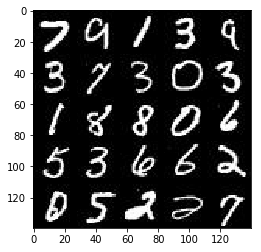

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

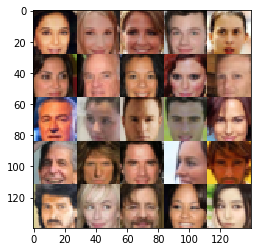

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse) as disc_scope:
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        
        #print ('x3 shape desc is:', x3.shape)
        flat = tf.reshape(x3, (-1, 4 * 4 *256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # now 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # now 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # now 14x14x128
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits) * 0.5
        # Output layer, 28x28x3
        #print ('out.shape', out.shape)
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, False),
                       feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    step = 0
    real_size = (data_shape[1],data_shape[2],data_shape[3])
    w, h, d = real_size
    
    input_real, input_z, lr = model_inputs(w, h, d, z_dim)
                
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size= (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               lr: learning_rate, 
                                               input_z: batch_z})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               lr: learning_rate, 
                                               input_z: batch_z})
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print ("Epoch {}/{} ...".format(epoch_i+1, epoch_count), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    """
                    gen_samples = sess.run(generator(input_z, data_shape[2], is_train=False),
                                          feed_dict={input_z: sample_z})
                    
                    samples.append(gen_samples)
                    """
                    
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
   
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ... Discriminator Loss: 1.1927... Generator Loss: 1.0159
Epoch 1/2 ... Discriminator Loss: 2.8760... Generator Loss: 0.2825
Epoch 1/2 ... Discriminator Loss: 3.0821... Generator Loss: 3.5580
Epoch 1/2 ... Discriminator Loss: 0.9414... Generator Loss: 1.6423
Epoch 1/2 ... Discriminator Loss: 0.8462... Generator Loss: 1.9158
Epoch 1/2 ... Discriminator Loss: 0.7276... Generator Loss: 2.7708
Epoch 1/2 ... Discriminator Loss: 0.7644... Generator Loss: 1.7715
Epoch 1/2 ... Discriminator Loss: 1.1129... Generator Loss: 1.8415
Epoch 1/2 ... Discriminator Loss: 1.1896... Generator Loss: 0.9359
Epoch 1/2 ... Discriminator Loss: 1.2705... Generator Loss: 1.2886


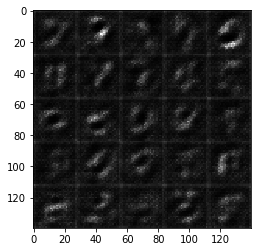

Epoch 1/2 ... Discriminator Loss: 1.1594... Generator Loss: 0.7813
Epoch 1/2 ... Discriminator Loss: 1.4258... Generator Loss: 0.8791
Epoch 1/2 ... Discriminator Loss: 1.0359... Generator Loss: 1.1164
Epoch 1/2 ... Discriminator Loss: 1.5163... Generator Loss: 0.7259
Epoch 1/2 ... Discriminator Loss: 1.0564... Generator Loss: 1.2594
Epoch 1/2 ... Discriminator Loss: 1.2386... Generator Loss: 1.5760
Epoch 1/2 ... Discriminator Loss: 1.2549... Generator Loss: 2.4618
Epoch 1/2 ... Discriminator Loss: 1.1314... Generator Loss: 0.8869
Epoch 1/2 ... Discriminator Loss: 1.1509... Generator Loss: 1.1307
Epoch 1/2 ... Discriminator Loss: 1.2424... Generator Loss: 0.9232


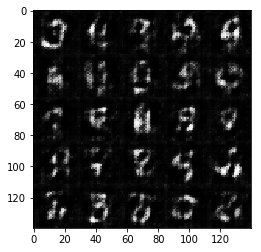

Epoch 1/2 ... Discriminator Loss: 1.1194... Generator Loss: 1.7520
Epoch 1/2 ... Discriminator Loss: 0.9633... Generator Loss: 1.3889
Epoch 1/2 ... Discriminator Loss: 1.4329... Generator Loss: 2.2909
Epoch 1/2 ... Discriminator Loss: 1.1739... Generator Loss: 1.1762
Epoch 1/2 ... Discriminator Loss: 1.1023... Generator Loss: 0.8859
Epoch 1/2 ... Discriminator Loss: 0.9762... Generator Loss: 1.6354
Epoch 1/2 ... Discriminator Loss: 1.1466... Generator Loss: 2.0020
Epoch 1/2 ... Discriminator Loss: 1.0860... Generator Loss: 1.6943
Epoch 1/2 ... Discriminator Loss: 1.1398... Generator Loss: 1.0881
Epoch 1/2 ... Discriminator Loss: 1.0661... Generator Loss: 1.1447


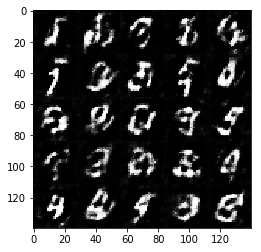

Epoch 1/2 ... Discriminator Loss: 1.0795... Generator Loss: 0.8352
Epoch 1/2 ... Discriminator Loss: 1.0489... Generator Loss: 0.9577
Epoch 1/2 ... Discriminator Loss: 1.0080... Generator Loss: 1.3764
Epoch 1/2 ... Discriminator Loss: 0.9246... Generator Loss: 0.9703
Epoch 1/2 ... Discriminator Loss: 0.9170... Generator Loss: 1.6508
Epoch 1/2 ... Discriminator Loss: 1.0210... Generator Loss: 1.6522
Epoch 1/2 ... Discriminator Loss: 0.7116... Generator Loss: 1.7262
Epoch 1/2 ... Discriminator Loss: 1.0117... Generator Loss: 1.5428
Epoch 1/2 ... Discriminator Loss: 0.9066... Generator Loss: 1.3917
Epoch 1/2 ... Discriminator Loss: 0.9850... Generator Loss: 1.4873


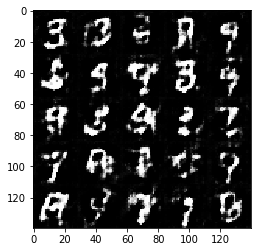

Epoch 1/2 ... Discriminator Loss: 1.1709... Generator Loss: 1.4080
Epoch 1/2 ... Discriminator Loss: 1.2957... Generator Loss: 0.7640
Epoch 1/2 ... Discriminator Loss: 1.1691... Generator Loss: 1.4703
Epoch 1/2 ... Discriminator Loss: 0.9294... Generator Loss: 1.6309
Epoch 1/2 ... Discriminator Loss: 0.9205... Generator Loss: 1.2813
Epoch 1/2 ... Discriminator Loss: 0.9762... Generator Loss: 1.5279
Epoch 1/2 ... Discriminator Loss: 0.8987... Generator Loss: 1.4852
Epoch 1/2 ... Discriminator Loss: 0.9833... Generator Loss: 1.5751
Epoch 1/2 ... Discriminator Loss: 1.1046... Generator Loss: 0.9712
Epoch 1/2 ... Discriminator Loss: 0.8783... Generator Loss: 1.7135


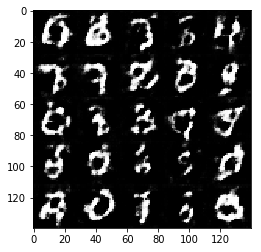

Epoch 1/2 ... Discriminator Loss: 0.8648... Generator Loss: 1.6209
Epoch 1/2 ... Discriminator Loss: 1.0132... Generator Loss: 1.2704
Epoch 1/2 ... Discriminator Loss: 1.0520... Generator Loss: 1.3502
Epoch 1/2 ... Discriminator Loss: 1.2783... Generator Loss: 0.9854
Epoch 1/2 ... Discriminator Loss: 0.8822... Generator Loss: 1.7302
Epoch 1/2 ... Discriminator Loss: 0.9225... Generator Loss: 1.4876
Epoch 1/2 ... Discriminator Loss: 0.9113... Generator Loss: 1.0699
Epoch 1/2 ... Discriminator Loss: 1.0384... Generator Loss: 1.1426
Epoch 1/2 ... Discriminator Loss: 1.0178... Generator Loss: 1.1510
Epoch 1/2 ... Discriminator Loss: 1.2237... Generator Loss: 1.5653


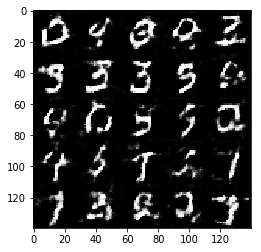

Epoch 1/2 ... Discriminator Loss: 0.8570... Generator Loss: 1.7905
Epoch 1/2 ... Discriminator Loss: 1.0374... Generator Loss: 1.3722
Epoch 1/2 ... Discriminator Loss: 1.3688... Generator Loss: 0.7308
Epoch 1/2 ... Discriminator Loss: 0.9415... Generator Loss: 1.8837
Epoch 1/2 ... Discriminator Loss: 1.4653... Generator Loss: 0.8113
Epoch 1/2 ... Discriminator Loss: 1.7321... Generator Loss: 0.5499
Epoch 1/2 ... Discriminator Loss: 0.9874... Generator Loss: 1.6983
Epoch 1/2 ... Discriminator Loss: 1.2367... Generator Loss: 0.9238
Epoch 1/2 ... Discriminator Loss: 1.1749... Generator Loss: 1.1148
Epoch 1/2 ... Discriminator Loss: 0.9838... Generator Loss: 1.1755


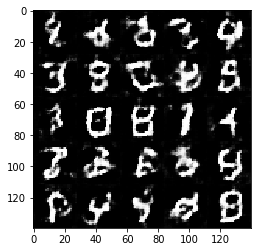

Epoch 1/2 ... Discriminator Loss: 1.1960... Generator Loss: 0.9828
Epoch 1/2 ... Discriminator Loss: 0.9155... Generator Loss: 1.0912
Epoch 1/2 ... Discriminator Loss: 0.8197... Generator Loss: 1.7237
Epoch 1/2 ... Discriminator Loss: 1.1567... Generator Loss: 0.9369
Epoch 1/2 ... Discriminator Loss: 1.0493... Generator Loss: 1.6887
Epoch 1/2 ... Discriminator Loss: 1.0428... Generator Loss: 1.2457
Epoch 1/2 ... Discriminator Loss: 0.8682... Generator Loss: 1.2613
Epoch 1/2 ... Discriminator Loss: 1.3198... Generator Loss: 0.6172
Epoch 1/2 ... Discriminator Loss: 0.9877... Generator Loss: 1.5715
Epoch 1/2 ... Discriminator Loss: 0.9160... Generator Loss: 2.2515


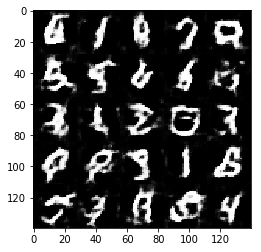

Epoch 1/2 ... Discriminator Loss: 1.1874... Generator Loss: 0.8810
Epoch 1/2 ... Discriminator Loss: 1.0539... Generator Loss: 1.0675
Epoch 1/2 ... Discriminator Loss: 1.3468... Generator Loss: 0.6870
Epoch 1/2 ... Discriminator Loss: 0.9317... Generator Loss: 1.3993
Epoch 1/2 ... Discriminator Loss: 1.1172... Generator Loss: 1.0840
Epoch 1/2 ... Discriminator Loss: 1.2200... Generator Loss: 1.2259
Epoch 1/2 ... Discriminator Loss: 1.2422... Generator Loss: 1.5238
Epoch 1/2 ... Discriminator Loss: 1.1701... Generator Loss: 0.6795
Epoch 1/2 ... Discriminator Loss: 0.9126... Generator Loss: 1.7344
Epoch 1/2 ... Discriminator Loss: 1.0301... Generator Loss: 0.8528


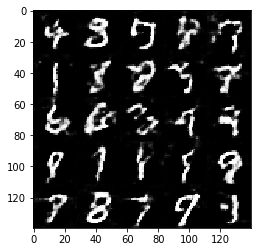

Epoch 1/2 ... Discriminator Loss: 0.9234... Generator Loss: 1.2844
Epoch 1/2 ... Discriminator Loss: 1.0571... Generator Loss: 0.8988
Epoch 1/2 ... Discriminator Loss: 1.2660... Generator Loss: 0.7615
Epoch 1/2 ... Discriminator Loss: 0.9470... Generator Loss: 1.1123
Epoch 1/2 ... Discriminator Loss: 1.1764... Generator Loss: 1.0912
Epoch 1/2 ... Discriminator Loss: 1.1263... Generator Loss: 1.3575
Epoch 1/2 ... Discriminator Loss: 1.5084... Generator Loss: 0.5681
Epoch 1/2 ... Discriminator Loss: 1.2644... Generator Loss: 0.8692
Epoch 1/2 ... Discriminator Loss: 0.8678... Generator Loss: 1.4534
Epoch 1/2 ... Discriminator Loss: 1.0354... Generator Loss: 0.9798


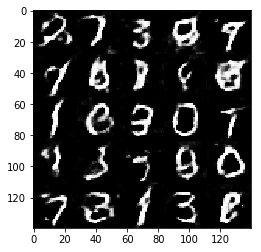

Epoch 1/2 ... Discriminator Loss: 0.9945... Generator Loss: 1.0576
Epoch 1/2 ... Discriminator Loss: 1.2101... Generator Loss: 0.9708
Epoch 1/2 ... Discriminator Loss: 1.0300... Generator Loss: 1.1222
Epoch 1/2 ... Discriminator Loss: 1.0682... Generator Loss: 2.2990
Epoch 1/2 ... Discriminator Loss: 0.9768... Generator Loss: 1.2703
Epoch 1/2 ... Discriminator Loss: 1.0474... Generator Loss: 1.0590
Epoch 1/2 ... Discriminator Loss: 1.2525... Generator Loss: 1.8897
Epoch 1/2 ... Discriminator Loss: 1.0335... Generator Loss: 1.4931
Epoch 1/2 ... Discriminator Loss: 1.1601... Generator Loss: 0.6556
Epoch 1/2 ... Discriminator Loss: 1.1529... Generator Loss: 1.2325


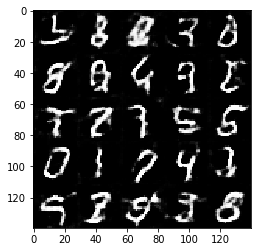

Epoch 1/2 ... Discriminator Loss: 1.3740... Generator Loss: 1.2644
Epoch 1/2 ... Discriminator Loss: 1.1368... Generator Loss: 1.0494
Epoch 1/2 ... Discriminator Loss: 0.9615... Generator Loss: 1.2908
Epoch 1/2 ... Discriminator Loss: 0.9679... Generator Loss: 1.2085
Epoch 1/2 ... Discriminator Loss: 1.1720... Generator Loss: 1.4593
Epoch 1/2 ... Discriminator Loss: 1.2480... Generator Loss: 1.1482
Epoch 1/2 ... Discriminator Loss: 1.0141... Generator Loss: 2.0423
Epoch 1/2 ... Discriminator Loss: 1.1373... Generator Loss: 2.3050
Epoch 1/2 ... Discriminator Loss: 1.0913... Generator Loss: 1.3344
Epoch 1/2 ... Discriminator Loss: 1.0661... Generator Loss: 1.1186


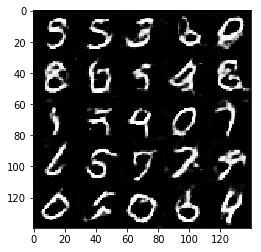

Epoch 1/2 ... Discriminator Loss: 0.8607... Generator Loss: 1.2522
Epoch 1/2 ... Discriminator Loss: 0.9880... Generator Loss: 1.2593
Epoch 1/2 ... Discriminator Loss: 1.0914... Generator Loss: 1.2913
Epoch 1/2 ... Discriminator Loss: 1.0202... Generator Loss: 0.9805
Epoch 1/2 ... Discriminator Loss: 1.0259... Generator Loss: 1.1987
Epoch 1/2 ... Discriminator Loss: 0.8787... Generator Loss: 1.5218
Epoch 1/2 ... Discriminator Loss: 1.0667... Generator Loss: 1.2153
Epoch 1/2 ... Discriminator Loss: 0.8283... Generator Loss: 1.4287
Epoch 1/2 ... Discriminator Loss: 0.8962... Generator Loss: 1.3251
Epoch 1/2 ... Discriminator Loss: 0.8816... Generator Loss: 1.8683


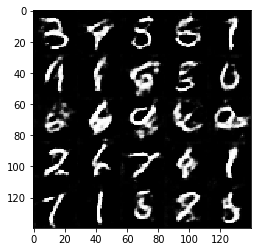

Epoch 1/2 ... Discriminator Loss: 1.1550... Generator Loss: 1.4339
Epoch 1/2 ... Discriminator Loss: 1.0356... Generator Loss: 1.2316
Epoch 1/2 ... Discriminator Loss: 0.9475... Generator Loss: 1.6194
Epoch 1/2 ... Discriminator Loss: 1.0383... Generator Loss: 0.9106
Epoch 1/2 ... Discriminator Loss: 0.9525... Generator Loss: 1.0491
Epoch 1/2 ... Discriminator Loss: 0.9215... Generator Loss: 1.5524
Epoch 1/2 ... Discriminator Loss: 0.9822... Generator Loss: 1.8203
Epoch 1/2 ... Discriminator Loss: 0.9631... Generator Loss: 1.4819
Epoch 1/2 ... Discriminator Loss: 1.0299... Generator Loss: 0.8675
Epoch 1/2 ... Discriminator Loss: 1.5528... Generator Loss: 2.7327


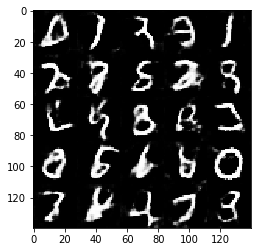

Epoch 1/2 ... Discriminator Loss: 1.2107... Generator Loss: 1.0836
Epoch 1/2 ... Discriminator Loss: 0.8635... Generator Loss: 1.6641
Epoch 1/2 ... Discriminator Loss: 0.8670... Generator Loss: 1.6239
Epoch 1/2 ... Discriminator Loss: 1.0157... Generator Loss: 1.2927
Epoch 1/2 ... Discriminator Loss: 0.8310... Generator Loss: 1.4045
Epoch 1/2 ... Discriminator Loss: 0.8427... Generator Loss: 1.8338
Epoch 1/2 ... Discriminator Loss: 0.8366... Generator Loss: 1.8944
Epoch 1/2 ... Discriminator Loss: 0.9141... Generator Loss: 0.9676
Epoch 1/2 ... Discriminator Loss: 0.9901... Generator Loss: 1.3523
Epoch 1/2 ... Discriminator Loss: 0.7919... Generator Loss: 1.6368


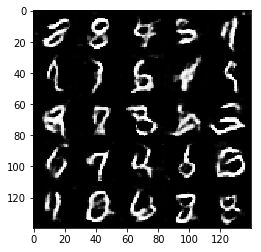

Epoch 1/2 ... Discriminator Loss: 0.8609... Generator Loss: 1.7577
Epoch 1/2 ... Discriminator Loss: 0.7907... Generator Loss: 1.2065
Epoch 1/2 ... Discriminator Loss: 0.8309... Generator Loss: 1.2885
Epoch 1/2 ... Discriminator Loss: 0.9215... Generator Loss: 1.4489
Epoch 1/2 ... Discriminator Loss: 0.9692... Generator Loss: 1.0688
Epoch 1/2 ... Discriminator Loss: 1.0048... Generator Loss: 2.0701
Epoch 1/2 ... Discriminator Loss: 1.0338... Generator Loss: 1.4166
Epoch 1/2 ... Discriminator Loss: 1.0225... Generator Loss: 0.9734
Epoch 1/2 ... Discriminator Loss: 0.9215... Generator Loss: 1.1518
Epoch 1/2 ... Discriminator Loss: 0.9408... Generator Loss: 0.9661


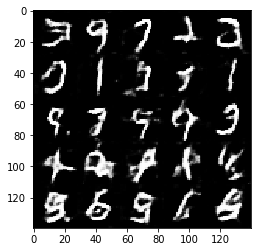

Epoch 1/2 ... Discriminator Loss: 0.8216... Generator Loss: 1.2974
Epoch 1/2 ... Discriminator Loss: 0.9245... Generator Loss: 1.1036
Epoch 1/2 ... Discriminator Loss: 0.8231... Generator Loss: 1.4745
Epoch 1/2 ... Discriminator Loss: 1.0771... Generator Loss: 1.2584
Epoch 1/2 ... Discriminator Loss: 0.8322... Generator Loss: 1.9022
Epoch 1/2 ... Discriminator Loss: 0.9109... Generator Loss: 0.9272
Epoch 1/2 ... Discriminator Loss: 1.2326... Generator Loss: 0.9986
Epoch 1/2 ... Discriminator Loss: 0.9170... Generator Loss: 1.3047
Epoch 1/2 ... Discriminator Loss: 1.0225... Generator Loss: 1.7369
Epoch 1/2 ... Discriminator Loss: 0.8439... Generator Loss: 1.6551


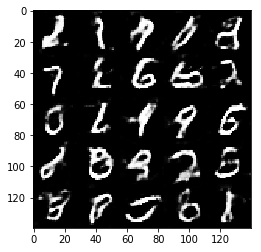

Epoch 1/2 ... Discriminator Loss: 0.8328... Generator Loss: 1.4083
Epoch 1/2 ... Discriminator Loss: 0.9786... Generator Loss: 1.0654
Epoch 1/2 ... Discriminator Loss: 1.0068... Generator Loss: 1.7757
Epoch 1/2 ... Discriminator Loss: 0.8936... Generator Loss: 1.4576
Epoch 1/2 ... Discriminator Loss: 0.9541... Generator Loss: 1.2715
Epoch 1/2 ... Discriminator Loss: 1.3827... Generator Loss: 0.7630
Epoch 1/2 ... Discriminator Loss: 0.7171... Generator Loss: 1.8706
Epoch 1/2 ... Discriminator Loss: 0.8692... Generator Loss: 1.4051
Epoch 1/2 ... Discriminator Loss: 0.8203... Generator Loss: 1.6199
Epoch 1/2 ... Discriminator Loss: 0.8428... Generator Loss: 1.8651


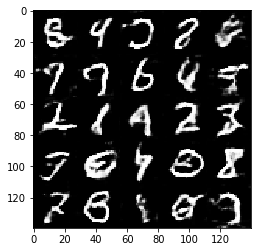

Epoch 1/2 ... Discriminator Loss: 0.8330... Generator Loss: 1.4811
Epoch 1/2 ... Discriminator Loss: 1.0800... Generator Loss: 1.7099
Epoch 1/2 ... Discriminator Loss: 0.9661... Generator Loss: 1.6362
Epoch 1/2 ... Discriminator Loss: 0.9660... Generator Loss: 0.9544
Epoch 1/2 ... Discriminator Loss: 1.0004... Generator Loss: 1.6122
Epoch 1/2 ... Discriminator Loss: 1.0080... Generator Loss: 0.8045
Epoch 1/2 ... Discriminator Loss: 1.1094... Generator Loss: 1.9896
Epoch 2/2 ... Discriminator Loss: 0.8695... Generator Loss: 1.3520
Epoch 2/2 ... Discriminator Loss: 1.0840... Generator Loss: 1.9422
Epoch 2/2 ... Discriminator Loss: 0.7476... Generator Loss: 2.0477


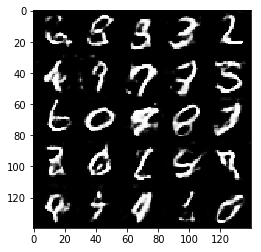

Epoch 2/2 ... Discriminator Loss: 1.0794... Generator Loss: 0.9726
Epoch 2/2 ... Discriminator Loss: 0.8434... Generator Loss: 1.4782
Epoch 2/2 ... Discriminator Loss: 0.7754... Generator Loss: 1.4607
Epoch 2/2 ... Discriminator Loss: 0.7770... Generator Loss: 2.1600
Epoch 2/2 ... Discriminator Loss: 1.0089... Generator Loss: 1.6380
Epoch 2/2 ... Discriminator Loss: 0.6540... Generator Loss: 2.2437
Epoch 2/2 ... Discriminator Loss: 1.0265... Generator Loss: 1.0539
Epoch 2/2 ... Discriminator Loss: 0.9128... Generator Loss: 1.0666
Epoch 2/2 ... Discriminator Loss: 0.7920... Generator Loss: 1.3763
Epoch 2/2 ... Discriminator Loss: 0.6562... Generator Loss: 1.8304


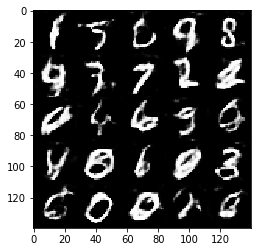

Epoch 2/2 ... Discriminator Loss: 0.7691... Generator Loss: 1.2575
Epoch 2/2 ... Discriminator Loss: 0.8645... Generator Loss: 1.4690
Epoch 2/2 ... Discriminator Loss: 0.6001... Generator Loss: 2.6849
Epoch 2/2 ... Discriminator Loss: 0.7645... Generator Loss: 2.0602
Epoch 2/2 ... Discriminator Loss: 1.6198... Generator Loss: 0.5731
Epoch 2/2 ... Discriminator Loss: 0.9538... Generator Loss: 1.4659
Epoch 2/2 ... Discriminator Loss: 0.7210... Generator Loss: 1.9481
Epoch 2/2 ... Discriminator Loss: 1.0322... Generator Loss: 1.9274
Epoch 2/2 ... Discriminator Loss: 0.8569... Generator Loss: 1.5358
Epoch 2/2 ... Discriminator Loss: 0.9344... Generator Loss: 1.9798


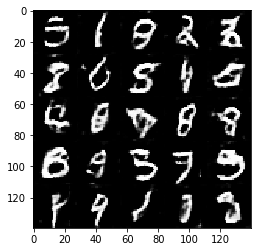

Epoch 2/2 ... Discriminator Loss: 0.7133... Generator Loss: 1.6525
Epoch 2/2 ... Discriminator Loss: 0.7117... Generator Loss: 1.2980
Epoch 2/2 ... Discriminator Loss: 0.9383... Generator Loss: 1.0729
Epoch 2/2 ... Discriminator Loss: 1.1493... Generator Loss: 1.1384
Epoch 2/2 ... Discriminator Loss: 0.7780... Generator Loss: 1.7322
Epoch 2/2 ... Discriminator Loss: 0.8024... Generator Loss: 1.9020
Epoch 2/2 ... Discriminator Loss: 0.8070... Generator Loss: 1.8444
Epoch 2/2 ... Discriminator Loss: 0.8803... Generator Loss: 1.3290
Epoch 2/2 ... Discriminator Loss: 0.8812... Generator Loss: 1.5574
Epoch 2/2 ... Discriminator Loss: 1.0004... Generator Loss: 2.4136


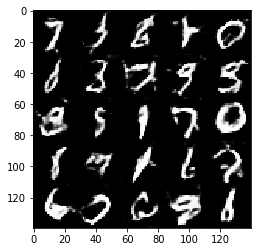

Epoch 2/2 ... Discriminator Loss: 0.6444... Generator Loss: 2.6019
Epoch 2/2 ... Discriminator Loss: 1.7827... Generator Loss: 0.5286
Epoch 2/2 ... Discriminator Loss: 0.8430... Generator Loss: 2.2066
Epoch 2/2 ... Discriminator Loss: 0.8438... Generator Loss: 1.1690
Epoch 2/2 ... Discriminator Loss: 0.7504... Generator Loss: 1.6066
Epoch 2/2 ... Discriminator Loss: 0.6767... Generator Loss: 1.7423
Epoch 2/2 ... Discriminator Loss: 0.7240... Generator Loss: 1.4418
Epoch 2/2 ... Discriminator Loss: 1.4169... Generator Loss: 0.4351
Epoch 2/2 ... Discriminator Loss: 0.8909... Generator Loss: 1.3622
Epoch 2/2 ... Discriminator Loss: 0.8161... Generator Loss: 1.8556


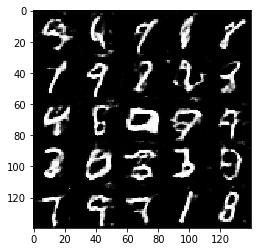

Epoch 2/2 ... Discriminator Loss: 0.6287... Generator Loss: 1.9485
Epoch 2/2 ... Discriminator Loss: 0.9257... Generator Loss: 2.7061
Epoch 2/2 ... Discriminator Loss: 0.7584... Generator Loss: 1.6415
Epoch 2/2 ... Discriminator Loss: 0.6107... Generator Loss: 1.5811
Epoch 2/2 ... Discriminator Loss: 0.6986... Generator Loss: 2.6492
Epoch 2/2 ... Discriminator Loss: 0.7254... Generator Loss: 1.4602
Epoch 2/2 ... Discriminator Loss: 0.6935... Generator Loss: 2.1685
Epoch 2/2 ... Discriminator Loss: 0.5864... Generator Loss: 2.3495
Epoch 2/2 ... Discriminator Loss: 0.7610... Generator Loss: 1.6787
Epoch 2/2 ... Discriminator Loss: 0.8164... Generator Loss: 2.7939


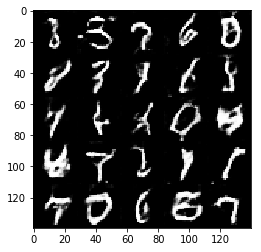

Epoch 2/2 ... Discriminator Loss: 0.8891... Generator Loss: 1.5321
Epoch 2/2 ... Discriminator Loss: 0.7874... Generator Loss: 2.2831
Epoch 2/2 ... Discriminator Loss: 1.0513... Generator Loss: 0.6438
Epoch 2/2 ... Discriminator Loss: 0.6121... Generator Loss: 2.3062
Epoch 2/2 ... Discriminator Loss: 0.6457... Generator Loss: 2.1850
Epoch 2/2 ... Discriminator Loss: 0.7780... Generator Loss: 1.0724
Epoch 2/2 ... Discriminator Loss: 0.6983... Generator Loss: 2.1256
Epoch 2/2 ... Discriminator Loss: 0.7203... Generator Loss: 1.8797
Epoch 2/2 ... Discriminator Loss: 0.5956... Generator Loss: 1.9743
Epoch 2/2 ... Discriminator Loss: 1.1077... Generator Loss: 4.0233


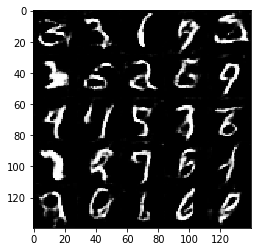

Epoch 2/2 ... Discriminator Loss: 0.8469... Generator Loss: 1.4720
Epoch 2/2 ... Discriminator Loss: 0.6693... Generator Loss: 2.6415
Epoch 2/2 ... Discriminator Loss: 0.8341... Generator Loss: 1.6477
Epoch 2/2 ... Discriminator Loss: 0.8449... Generator Loss: 1.6010
Epoch 2/2 ... Discriminator Loss: 0.9241... Generator Loss: 1.0070
Epoch 2/2 ... Discriminator Loss: 0.9206... Generator Loss: 1.3750
Epoch 2/2 ... Discriminator Loss: 0.6256... Generator Loss: 1.9479
Epoch 2/2 ... Discriminator Loss: 0.7858... Generator Loss: 2.4491
Epoch 2/2 ... Discriminator Loss: 0.8304... Generator Loss: 1.7410
Epoch 2/2 ... Discriminator Loss: 0.8825... Generator Loss: 1.2091


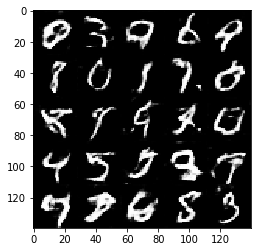

Epoch 2/2 ... Discriminator Loss: 0.5131... Generator Loss: 2.4083
Epoch 2/2 ... Discriminator Loss: 0.8262... Generator Loss: 1.7029
Epoch 2/2 ... Discriminator Loss: 0.7383... Generator Loss: 1.7122
Epoch 2/2 ... Discriminator Loss: 0.6591... Generator Loss: 1.7692
Epoch 2/2 ... Discriminator Loss: 0.6062... Generator Loss: 1.5068
Epoch 2/2 ... Discriminator Loss: 0.6217... Generator Loss: 1.6198
Epoch 2/2 ... Discriminator Loss: 0.8638... Generator Loss: 1.4893
Epoch 2/2 ... Discriminator Loss: 0.8681... Generator Loss: 3.1455
Epoch 2/2 ... Discriminator Loss: 0.7213... Generator Loss: 1.7288
Epoch 2/2 ... Discriminator Loss: 0.7418... Generator Loss: 3.0212


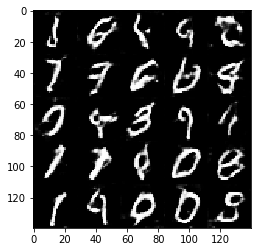

Epoch 2/2 ... Discriminator Loss: 0.8093... Generator Loss: 1.1433
Epoch 2/2 ... Discriminator Loss: 0.9609... Generator Loss: 1.1854
Epoch 2/2 ... Discriminator Loss: 0.9159... Generator Loss: 1.5024
Epoch 2/2 ... Discriminator Loss: 0.7389... Generator Loss: 2.2369
Epoch 2/2 ... Discriminator Loss: 0.6833... Generator Loss: 2.6286
Epoch 2/2 ... Discriminator Loss: 0.9124... Generator Loss: 2.8704
Epoch 2/2 ... Discriminator Loss: 0.7002... Generator Loss: 1.3026
Epoch 2/2 ... Discriminator Loss: 0.7808... Generator Loss: 1.6251
Epoch 2/2 ... Discriminator Loss: 0.6075... Generator Loss: 2.0988
Epoch 2/2 ... Discriminator Loss: 0.6147... Generator Loss: 2.1806


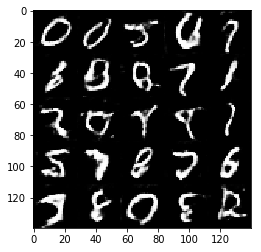

Epoch 2/2 ... Discriminator Loss: 0.7381... Generator Loss: 3.2444
Epoch 2/2 ... Discriminator Loss: 0.6793... Generator Loss: 2.5739
Epoch 2/2 ... Discriminator Loss: 0.7230... Generator Loss: 2.4171
Epoch 2/2 ... Discriminator Loss: 0.5982... Generator Loss: 1.8838
Epoch 2/2 ... Discriminator Loss: 0.7863... Generator Loss: 2.5948
Epoch 2/2 ... Discriminator Loss: 0.7921... Generator Loss: 1.5272
Epoch 2/2 ... Discriminator Loss: 0.8679... Generator Loss: 1.8243
Epoch 2/2 ... Discriminator Loss: 0.5723... Generator Loss: 2.1598
Epoch 2/2 ... Discriminator Loss: 0.5652... Generator Loss: 2.6949
Epoch 2/2 ... Discriminator Loss: 0.6220... Generator Loss: 2.5321


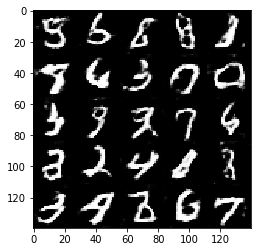

Epoch 2/2 ... Discriminator Loss: 1.0694... Generator Loss: 1.0719
Epoch 2/2 ... Discriminator Loss: 0.5053... Generator Loss: 2.3630
Epoch 2/2 ... Discriminator Loss: 1.0472... Generator Loss: 1.1475
Epoch 2/2 ... Discriminator Loss: 1.0822... Generator Loss: 0.8368
Epoch 2/2 ... Discriminator Loss: 0.7538... Generator Loss: 1.4086
Epoch 2/2 ... Discriminator Loss: 0.8813... Generator Loss: 1.0082
Epoch 2/2 ... Discriminator Loss: 0.9627... Generator Loss: 1.6177
Epoch 2/2 ... Discriminator Loss: 2.4849... Generator Loss: 0.1849
Epoch 2/2 ... Discriminator Loss: 0.8780... Generator Loss: 1.7318
Epoch 2/2 ... Discriminator Loss: 0.5811... Generator Loss: 1.7874


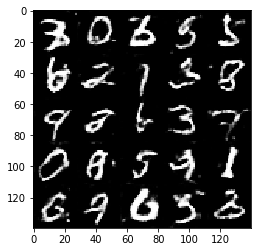

Epoch 2/2 ... Discriminator Loss: 0.5951... Generator Loss: 2.0532
Epoch 2/2 ... Discriminator Loss: 0.7212... Generator Loss: 2.0581
Epoch 2/2 ... Discriminator Loss: 0.5223... Generator Loss: 2.2610
Epoch 2/2 ... Discriminator Loss: 0.7640... Generator Loss: 2.3733
Epoch 2/2 ... Discriminator Loss: 0.6751... Generator Loss: 1.9943
Epoch 2/2 ... Discriminator Loss: 0.6330... Generator Loss: 1.4297
Epoch 2/2 ... Discriminator Loss: 0.7302... Generator Loss: 1.8554
Epoch 2/2 ... Discriminator Loss: 0.6602... Generator Loss: 2.2581
Epoch 2/2 ... Discriminator Loss: 0.8895... Generator Loss: 1.9752
Epoch 2/2 ... Discriminator Loss: 0.5604... Generator Loss: 2.5032


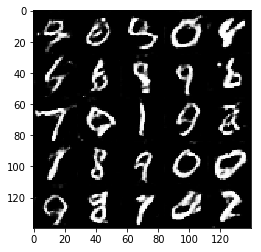

Epoch 2/2 ... Discriminator Loss: 0.7345... Generator Loss: 2.2168
Epoch 2/2 ... Discriminator Loss: 0.7144... Generator Loss: 1.2513
Epoch 2/2 ... Discriminator Loss: 0.6045... Generator Loss: 2.4588
Epoch 2/2 ... Discriminator Loss: 0.5757... Generator Loss: 2.4897
Epoch 2/2 ... Discriminator Loss: 0.9154... Generator Loss: 1.0451
Epoch 2/2 ... Discriminator Loss: 0.5747... Generator Loss: 2.0422
Epoch 2/2 ... Discriminator Loss: 0.8069... Generator Loss: 1.4426
Epoch 2/2 ... Discriminator Loss: 0.5691... Generator Loss: 2.2453
Epoch 2/2 ... Discriminator Loss: 0.7423... Generator Loss: 3.1929
Epoch 2/2 ... Discriminator Loss: 0.6159... Generator Loss: 1.6619


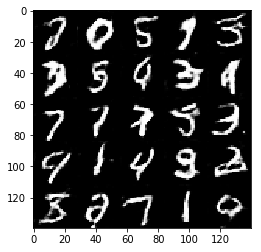

Epoch 2/2 ... Discriminator Loss: 0.8567... Generator Loss: 2.2997
Epoch 2/2 ... Discriminator Loss: 0.7960... Generator Loss: 2.2979
Epoch 2/2 ... Discriminator Loss: 0.6478... Generator Loss: 1.4938
Epoch 2/2 ... Discriminator Loss: 0.8301... Generator Loss: 1.5572
Epoch 2/2 ... Discriminator Loss: 0.6696... Generator Loss: 2.3876
Epoch 2/2 ... Discriminator Loss: 0.7860... Generator Loss: 2.4470
Epoch 2/2 ... Discriminator Loss: 0.6933... Generator Loss: 2.1043
Epoch 2/2 ... Discriminator Loss: 0.7114... Generator Loss: 3.1898
Epoch 2/2 ... Discriminator Loss: 0.6368... Generator Loss: 2.1309
Epoch 2/2 ... Discriminator Loss: 0.7450... Generator Loss: 2.0531


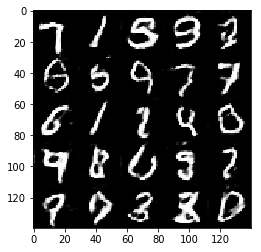

Epoch 2/2 ... Discriminator Loss: 0.6425... Generator Loss: 1.7780
Epoch 2/2 ... Discriminator Loss: 0.5900... Generator Loss: 2.5727
Epoch 2/2 ... Discriminator Loss: 0.7725... Generator Loss: 3.2000
Epoch 2/2 ... Discriminator Loss: 0.8154... Generator Loss: 2.1417
Epoch 2/2 ... Discriminator Loss: 0.6201... Generator Loss: 1.5881
Epoch 2/2 ... Discriminator Loss: 0.5396... Generator Loss: 3.0365
Epoch 2/2 ... Discriminator Loss: 1.1421... Generator Loss: 0.7906
Epoch 2/2 ... Discriminator Loss: 0.5360... Generator Loss: 1.9864
Epoch 2/2 ... Discriminator Loss: 0.7859... Generator Loss: 1.4953
Epoch 2/2 ... Discriminator Loss: 0.5691... Generator Loss: 2.3443


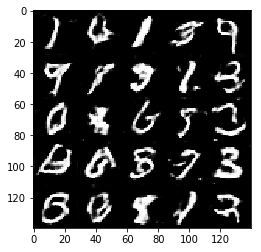

Epoch 2/2 ... Discriminator Loss: 0.6515... Generator Loss: 2.3509
Epoch 2/2 ... Discriminator Loss: 0.6858... Generator Loss: 1.5328
Epoch 2/2 ... Discriminator Loss: 0.8379... Generator Loss: 1.9314
Epoch 2/2 ... Discriminator Loss: 0.5193... Generator Loss: 3.0172
Epoch 2/2 ... Discriminator Loss: 0.6519... Generator Loss: 2.3549
Epoch 2/2 ... Discriminator Loss: 0.6615... Generator Loss: 3.2757
Epoch 2/2 ... Discriminator Loss: 0.8234... Generator Loss: 1.2689
Epoch 2/2 ... Discriminator Loss: 0.5911... Generator Loss: 1.6306
Epoch 2/2 ... Discriminator Loss: 0.5395... Generator Loss: 2.2430
Epoch 2/2 ... Discriminator Loss: 0.8390... Generator Loss: 1.2446


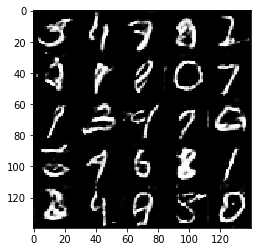

Epoch 2/2 ... Discriminator Loss: 0.6444... Generator Loss: 2.1228
Epoch 2/2 ... Discriminator Loss: 0.7334... Generator Loss: 2.6509
Epoch 2/2 ... Discriminator Loss: 0.6230... Generator Loss: 2.3675
Epoch 2/2 ... Discriminator Loss: 0.5609... Generator Loss: 2.8668
Epoch 2/2 ... Discriminator Loss: 0.8622... Generator Loss: 1.4265
Epoch 2/2 ... Discriminator Loss: 0.7161... Generator Loss: 2.4123
Epoch 2/2 ... Discriminator Loss: 0.4737... Generator Loss: 2.3488
Epoch 2/2 ... Discriminator Loss: 0.8454... Generator Loss: 3.7450
Epoch 2/2 ... Discriminator Loss: 0.6420... Generator Loss: 2.5188
Epoch 2/2 ... Discriminator Loss: 0.5246... Generator Loss: 1.8252


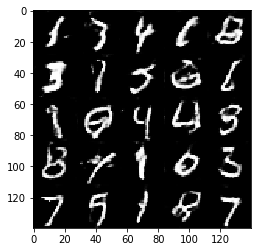

Epoch 2/2 ... Discriminator Loss: 0.6453... Generator Loss: 1.9221
Epoch 2/2 ... Discriminator Loss: 0.6321... Generator Loss: 2.5147
Epoch 2/2 ... Discriminator Loss: 1.1801... Generator Loss: 3.6441
Epoch 2/2 ... Discriminator Loss: 0.5134... Generator Loss: 1.4678
Epoch 2/2 ... Discriminator Loss: 0.6566... Generator Loss: 1.9592
Epoch 2/2 ... Discriminator Loss: 0.6526... Generator Loss: 3.9327
Epoch 2/2 ... Discriminator Loss: 0.7512... Generator Loss: 1.1334
Epoch 2/2 ... Discriminator Loss: 0.4978... Generator Loss: 1.9766
Epoch 2/2 ... Discriminator Loss: 0.6133... Generator Loss: 3.4229
Epoch 2/2 ... Discriminator Loss: 1.1643... Generator Loss: 0.7929


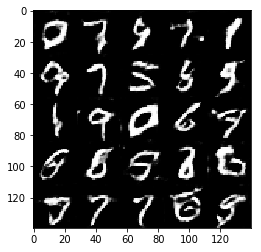

Epoch 2/2 ... Discriminator Loss: 0.7634... Generator Loss: 1.3323
Epoch 2/2 ... Discriminator Loss: 0.8945... Generator Loss: 3.1434
Epoch 2/2 ... Discriminator Loss: 0.9673... Generator Loss: 1.6463
Epoch 2/2 ... Discriminator Loss: 0.5849... Generator Loss: 2.8299
Epoch 2/2 ... Discriminator Loss: 0.5841... Generator Loss: 2.3505


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5
# alpha = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ... Discriminator Loss: 0.6115... Generator Loss: 2.2417
Epoch 1/1 ... Discriminator Loss: 0.6274... Generator Loss: 3.2653
Epoch 1/1 ... Discriminator Loss: 0.4734... Generator Loss: 4.1059
Epoch 1/1 ... Discriminator Loss: 0.6043... Generator Loss: 5.9338
Epoch 1/1 ... Discriminator Loss: 1.3282... Generator Loss: 7.3250
Epoch 1/1 ... Discriminator Loss: 1.1255... Generator Loss: 0.9524
Epoch 1/1 ... Discriminator Loss: 0.9538... Generator Loss: 1.3710
Epoch 1/1 ... Discriminator Loss: 0.9754... Generator Loss: 2.8128
Epoch 1/1 ... Discriminator Loss: 0.8704... Generator Loss: 1.3442
Epoch 1/1 ... Discriminator Loss: 0.8424... Generator Loss: 1.7230


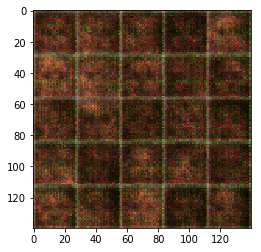

Epoch 1/1 ... Discriminator Loss: 0.4692... Generator Loss: 2.6273
Epoch 1/1 ... Discriminator Loss: 0.5353... Generator Loss: 3.0168
Epoch 1/1 ... Discriminator Loss: 0.5640... Generator Loss: 2.3761
Epoch 1/1 ... Discriminator Loss: 0.5247... Generator Loss: 2.5508
Epoch 1/1 ... Discriminator Loss: 0.6413... Generator Loss: 1.7326
Epoch 1/1 ... Discriminator Loss: 0.4429... Generator Loss: 3.2542
Epoch 1/1 ... Discriminator Loss: 0.4713... Generator Loss: 3.4304
Epoch 1/1 ... Discriminator Loss: 0.4833... Generator Loss: 4.8779
Epoch 1/1 ... Discriminator Loss: 0.5275... Generator Loss: 2.8473
Epoch 1/1 ... Discriminator Loss: 0.6011... Generator Loss: 2.3084


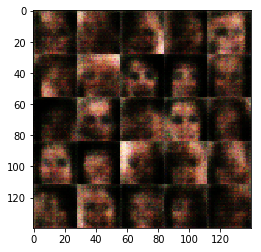

Epoch 1/1 ... Discriminator Loss: 0.4081... Generator Loss: 3.6910
Epoch 1/1 ... Discriminator Loss: 2.1331... Generator Loss: 9.0945
Epoch 1/1 ... Discriminator Loss: 0.4970... Generator Loss: 3.0399
Epoch 1/1 ... Discriminator Loss: 0.5197... Generator Loss: 2.3807
Epoch 1/1 ... Discriminator Loss: 0.5667... Generator Loss: 2.6337
Epoch 1/1 ... Discriminator Loss: 0.5537... Generator Loss: 3.1758
Epoch 1/1 ... Discriminator Loss: 0.8739... Generator Loss: 4.1424
Epoch 1/1 ... Discriminator Loss: 1.0737... Generator Loss: 1.0461
Epoch 1/1 ... Discriminator Loss: 0.6230... Generator Loss: 2.2320
Epoch 1/1 ... Discriminator Loss: 0.8876... Generator Loss: 1.3321


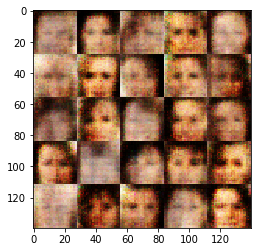

Epoch 1/1 ... Discriminator Loss: 0.7451... Generator Loss: 2.0905
Epoch 1/1 ... Discriminator Loss: 0.8029... Generator Loss: 1.8388
Epoch 1/1 ... Discriminator Loss: 0.9743... Generator Loss: 1.8112
Epoch 1/1 ... Discriminator Loss: 0.7224... Generator Loss: 1.9848
Epoch 1/1 ... Discriminator Loss: 0.8643... Generator Loss: 2.1428
Epoch 1/1 ... Discriminator Loss: 0.7970... Generator Loss: 1.2894
Epoch 1/1 ... Discriminator Loss: 0.9323... Generator Loss: 2.1276
Epoch 1/1 ... Discriminator Loss: 0.7018... Generator Loss: 2.0632
Epoch 1/1 ... Discriminator Loss: 1.0316... Generator Loss: 1.1644
Epoch 1/1 ... Discriminator Loss: 0.8671... Generator Loss: 2.0556


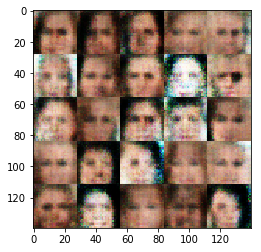

Epoch 1/1 ... Discriminator Loss: 0.7585... Generator Loss: 1.8091
Epoch 1/1 ... Discriminator Loss: 0.8529... Generator Loss: 1.3642
Epoch 1/1 ... Discriminator Loss: 0.8508... Generator Loss: 1.4234
Epoch 1/1 ... Discriminator Loss: 0.9969... Generator Loss: 0.9448
Epoch 1/1 ... Discriminator Loss: 0.7061... Generator Loss: 1.9526
Epoch 1/1 ... Discriminator Loss: 1.1683... Generator Loss: 4.0622
Epoch 1/1 ... Discriminator Loss: 0.6064... Generator Loss: 2.4116
Epoch 1/1 ... Discriminator Loss: 0.8484... Generator Loss: 1.3844
Epoch 1/1 ... Discriminator Loss: 0.7858... Generator Loss: 2.4955
Epoch 1/1 ... Discriminator Loss: 1.1062... Generator Loss: 0.7920


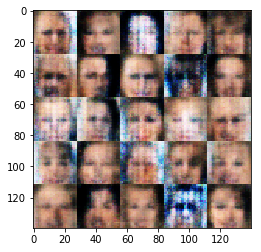

Epoch 1/1 ... Discriminator Loss: 0.8869... Generator Loss: 1.4175
Epoch 1/1 ... Discriminator Loss: 0.9156... Generator Loss: 2.1474
Epoch 1/1 ... Discriminator Loss: 1.0904... Generator Loss: 1.1418
Epoch 1/1 ... Discriminator Loss: 0.8325... Generator Loss: 2.0182
Epoch 1/1 ... Discriminator Loss: 0.9871... Generator Loss: 1.1463
Epoch 1/1 ... Discriminator Loss: 1.0486... Generator Loss: 0.9717
Epoch 1/1 ... Discriminator Loss: 0.9252... Generator Loss: 1.2454
Epoch 1/1 ... Discriminator Loss: 1.4179... Generator Loss: 0.7290
Epoch 1/1 ... Discriminator Loss: 1.0886... Generator Loss: 0.9092
Epoch 1/1 ... Discriminator Loss: 0.9017... Generator Loss: 1.3198


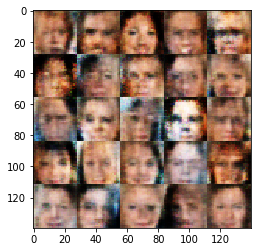

Epoch 1/1 ... Discriminator Loss: 0.9457... Generator Loss: 2.2592
Epoch 1/1 ... Discriminator Loss: 1.3503... Generator Loss: 2.2133
Epoch 1/1 ... Discriminator Loss: 1.0599... Generator Loss: 1.7797
Epoch 1/1 ... Discriminator Loss: 0.9978... Generator Loss: 1.6255
Epoch 1/1 ... Discriminator Loss: 0.9825... Generator Loss: 1.5941
Epoch 1/1 ... Discriminator Loss: 1.2019... Generator Loss: 0.9804
Epoch 1/1 ... Discriminator Loss: 1.2217... Generator Loss: 0.9477
Epoch 1/1 ... Discriminator Loss: 0.9940... Generator Loss: 1.9347
Epoch 1/1 ... Discriminator Loss: 0.9535... Generator Loss: 1.4088
Epoch 1/1 ... Discriminator Loss: 1.1641... Generator Loss: 1.0357


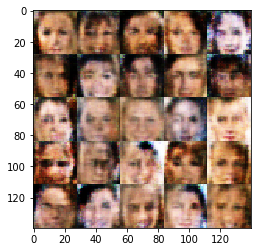

Epoch 1/1 ... Discriminator Loss: 0.8954... Generator Loss: 1.6596
Epoch 1/1 ... Discriminator Loss: 0.8645... Generator Loss: 1.4923
Epoch 1/1 ... Discriminator Loss: 0.9219... Generator Loss: 1.5293
Epoch 1/1 ... Discriminator Loss: 0.9567... Generator Loss: 1.4940
Epoch 1/1 ... Discriminator Loss: 1.0177... Generator Loss: 1.7278
Epoch 1/1 ... Discriminator Loss: 0.8456... Generator Loss: 1.6376
Epoch 1/1 ... Discriminator Loss: 1.0465... Generator Loss: 1.5894
Epoch 1/1 ... Discriminator Loss: 0.8445... Generator Loss: 1.2951
Epoch 1/1 ... Discriminator Loss: 1.0400... Generator Loss: 1.6258
Epoch 1/1 ... Discriminator Loss: 1.1699... Generator Loss: 2.2870


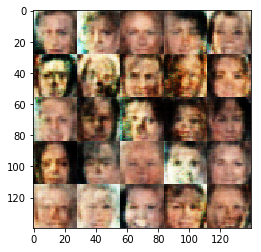

Epoch 1/1 ... Discriminator Loss: 1.3678... Generator Loss: 0.7439
Epoch 1/1 ... Discriminator Loss: 1.1796... Generator Loss: 1.8082
Epoch 1/1 ... Discriminator Loss: 0.9136... Generator Loss: 1.7157
Epoch 1/1 ... Discriminator Loss: 1.2870... Generator Loss: 1.3579
Epoch 1/1 ... Discriminator Loss: 1.1324... Generator Loss: 1.3268
Epoch 1/1 ... Discriminator Loss: 1.1524... Generator Loss: 0.8312
Epoch 1/1 ... Discriminator Loss: 1.2000... Generator Loss: 1.0696
Epoch 1/1 ... Discriminator Loss: 1.1384... Generator Loss: 2.3372
Epoch 1/1 ... Discriminator Loss: 0.9569... Generator Loss: 1.5324
Epoch 1/1 ... Discriminator Loss: 1.1043... Generator Loss: 1.1485


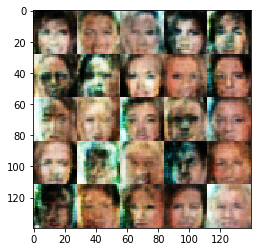

Epoch 1/1 ... Discriminator Loss: 1.1240... Generator Loss: 1.5308
Epoch 1/1 ... Discriminator Loss: 1.1700... Generator Loss: 1.0798
Epoch 1/1 ... Discriminator Loss: 0.9494... Generator Loss: 1.0261
Epoch 1/1 ... Discriminator Loss: 0.9016... Generator Loss: 1.2521
Epoch 1/1 ... Discriminator Loss: 1.1637... Generator Loss: 1.5250
Epoch 1/1 ... Discriminator Loss: 1.2753... Generator Loss: 1.0119
Epoch 1/1 ... Discriminator Loss: 1.1460... Generator Loss: 0.9877
Epoch 1/1 ... Discriminator Loss: 1.2786... Generator Loss: 1.2979
Epoch 1/1 ... Discriminator Loss: 0.9768... Generator Loss: 0.9071
Epoch 1/1 ... Discriminator Loss: 1.5471... Generator Loss: 0.5387


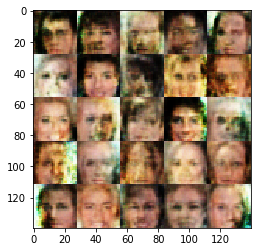

Epoch 1/1 ... Discriminator Loss: 1.0284... Generator Loss: 1.3047
Epoch 1/1 ... Discriminator Loss: 1.0874... Generator Loss: 1.2589
Epoch 1/1 ... Discriminator Loss: 1.1190... Generator Loss: 1.6282
Epoch 1/1 ... Discriminator Loss: 1.1808... Generator Loss: 1.7128
Epoch 1/1 ... Discriminator Loss: 1.1327... Generator Loss: 0.8739
Epoch 1/1 ... Discriminator Loss: 1.2200... Generator Loss: 1.3754
Epoch 1/1 ... Discriminator Loss: 1.0383... Generator Loss: 1.5286
Epoch 1/1 ... Discriminator Loss: 1.0912... Generator Loss: 1.1339
Epoch 1/1 ... Discriminator Loss: 0.9307... Generator Loss: 1.5714
Epoch 1/1 ... Discriminator Loss: 1.3048... Generator Loss: 0.8528


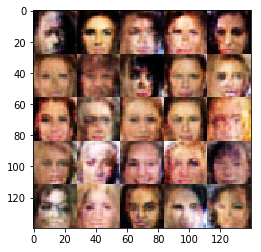

Epoch 1/1 ... Discriminator Loss: 1.1271... Generator Loss: 0.9604
Epoch 1/1 ... Discriminator Loss: 0.9653... Generator Loss: 1.4973
Epoch 1/1 ... Discriminator Loss: 1.0251... Generator Loss: 1.3870
Epoch 1/1 ... Discriminator Loss: 1.1003... Generator Loss: 1.4129
Epoch 1/1 ... Discriminator Loss: 0.9936... Generator Loss: 1.2551
Epoch 1/1 ... Discriminator Loss: 1.0523... Generator Loss: 1.2150
Epoch 1/1 ... Discriminator Loss: 1.0152... Generator Loss: 1.2435
Epoch 1/1 ... Discriminator Loss: 1.0805... Generator Loss: 1.1659
Epoch 1/1 ... Discriminator Loss: 1.1753... Generator Loss: 0.9490
Epoch 1/1 ... Discriminator Loss: 0.9603... Generator Loss: 1.2538


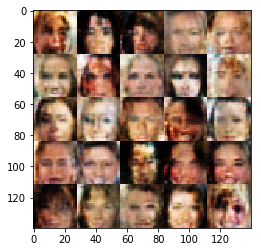

Epoch 1/1 ... Discriminator Loss: 1.1579... Generator Loss: 1.0836
Epoch 1/1 ... Discriminator Loss: 1.1912... Generator Loss: 1.2474
Epoch 1/1 ... Discriminator Loss: 0.9525... Generator Loss: 1.4578
Epoch 1/1 ... Discriminator Loss: 1.0447... Generator Loss: 1.3619
Epoch 1/1 ... Discriminator Loss: 0.9734... Generator Loss: 1.4902
Epoch 1/1 ... Discriminator Loss: 1.3456... Generator Loss: 0.8272
Epoch 1/1 ... Discriminator Loss: 1.0474... Generator Loss: 1.2404
Epoch 1/1 ... Discriminator Loss: 1.3112... Generator Loss: 0.7443
Epoch 1/1 ... Discriminator Loss: 1.0337... Generator Loss: 0.8330
Epoch 1/1 ... Discriminator Loss: 1.0573... Generator Loss: 0.8398


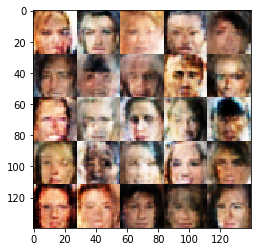

Epoch 1/1 ... Discriminator Loss: 1.1192... Generator Loss: 1.2938
Epoch 1/1 ... Discriminator Loss: 1.1940... Generator Loss: 0.9730
Epoch 1/1 ... Discriminator Loss: 1.1648... Generator Loss: 1.5430
Epoch 1/1 ... Discriminator Loss: 1.2275... Generator Loss: 1.5415
Epoch 1/1 ... Discriminator Loss: 1.1137... Generator Loss: 1.2767
Epoch 1/1 ... Discriminator Loss: 1.0833... Generator Loss: 1.4418
Epoch 1/1 ... Discriminator Loss: 1.3092... Generator Loss: 0.7817
Epoch 1/1 ... Discriminator Loss: 1.2308... Generator Loss: 0.7280
Epoch 1/1 ... Discriminator Loss: 1.1273... Generator Loss: 1.1851
Epoch 1/1 ... Discriminator Loss: 1.2132... Generator Loss: 1.3417


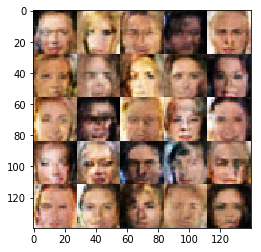

Epoch 1/1 ... Discriminator Loss: 1.0102... Generator Loss: 1.5899
Epoch 1/1 ... Discriminator Loss: 1.0202... Generator Loss: 1.2698
Epoch 1/1 ... Discriminator Loss: 1.0075... Generator Loss: 1.1023
Epoch 1/1 ... Discriminator Loss: 1.1664... Generator Loss: 0.8049
Epoch 1/1 ... Discriminator Loss: 1.0185... Generator Loss: 1.6712
Epoch 1/1 ... Discriminator Loss: 1.1848... Generator Loss: 1.0849
Epoch 1/1 ... Discriminator Loss: 1.1394... Generator Loss: 0.9180
Epoch 1/1 ... Discriminator Loss: 0.8766... Generator Loss: 1.2106
Epoch 1/1 ... Discriminator Loss: 1.1993... Generator Loss: 0.9206
Epoch 1/1 ... Discriminator Loss: 0.9174... Generator Loss: 1.1076


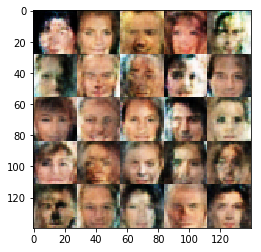

Epoch 1/1 ... Discriminator Loss: 1.1832... Generator Loss: 1.4527
Epoch 1/1 ... Discriminator Loss: 1.1365... Generator Loss: 0.9502
Epoch 1/1 ... Discriminator Loss: 1.1343... Generator Loss: 0.9551
Epoch 1/1 ... Discriminator Loss: 1.0334... Generator Loss: 0.9129
Epoch 1/1 ... Discriminator Loss: 1.2178... Generator Loss: 0.7153
Epoch 1/1 ... Discriminator Loss: 0.9841... Generator Loss: 1.1573
Epoch 1/1 ... Discriminator Loss: 1.0428... Generator Loss: 1.0302
Epoch 1/1 ... Discriminator Loss: 1.4423... Generator Loss: 0.5626
Epoch 1/1 ... Discriminator Loss: 1.1161... Generator Loss: 1.1784
Epoch 1/1 ... Discriminator Loss: 1.0265... Generator Loss: 1.0071


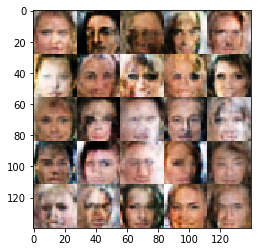

Epoch 1/1 ... Discriminator Loss: 1.0810... Generator Loss: 1.2061
Epoch 1/1 ... Discriminator Loss: 1.0595... Generator Loss: 1.3853
Epoch 1/1 ... Discriminator Loss: 1.0752... Generator Loss: 0.9686
Epoch 1/1 ... Discriminator Loss: 1.1804... Generator Loss: 0.8637
Epoch 1/1 ... Discriminator Loss: 0.9569... Generator Loss: 1.0327
Epoch 1/1 ... Discriminator Loss: 1.1298... Generator Loss: 1.5977
Epoch 1/1 ... Discriminator Loss: 1.2448... Generator Loss: 0.9195
Epoch 1/1 ... Discriminator Loss: 1.0353... Generator Loss: 1.1006
Epoch 1/1 ... Discriminator Loss: 1.2464... Generator Loss: 0.7491
Epoch 1/1 ... Discriminator Loss: 1.0978... Generator Loss: 0.9992


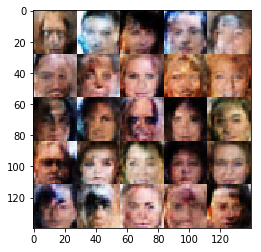

Epoch 1/1 ... Discriminator Loss: 1.0552... Generator Loss: 1.4642
Epoch 1/1 ... Discriminator Loss: 1.2330... Generator Loss: 0.6740
Epoch 1/1 ... Discriminator Loss: 1.0256... Generator Loss: 0.9775
Epoch 1/1 ... Discriminator Loss: 1.1682... Generator Loss: 1.0051
Epoch 1/1 ... Discriminator Loss: 1.0632... Generator Loss: 1.0807
Epoch 1/1 ... Discriminator Loss: 1.2021... Generator Loss: 2.2777
Epoch 1/1 ... Discriminator Loss: 0.8226... Generator Loss: 1.0535
Epoch 1/1 ... Discriminator Loss: 1.0348... Generator Loss: 0.9411
Epoch 1/1 ... Discriminator Loss: 0.9351... Generator Loss: 1.4902
Epoch 1/1 ... Discriminator Loss: 1.1110... Generator Loss: 0.9212


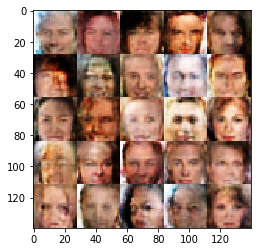

Epoch 1/1 ... Discriminator Loss: 0.9374... Generator Loss: 1.2809
Epoch 1/1 ... Discriminator Loss: 0.9559... Generator Loss: 1.3467
Epoch 1/1 ... Discriminator Loss: 1.1371... Generator Loss: 1.5139
Epoch 1/1 ... Discriminator Loss: 1.0788... Generator Loss: 0.8953
Epoch 1/1 ... Discriminator Loss: 1.0818... Generator Loss: 1.0438
Epoch 1/1 ... Discriminator Loss: 1.1335... Generator Loss: 1.4680
Epoch 1/1 ... Discriminator Loss: 1.2855... Generator Loss: 0.8331
Epoch 1/1 ... Discriminator Loss: 1.1303... Generator Loss: 1.0456
Epoch 1/1 ... Discriminator Loss: 0.9859... Generator Loss: 1.1254
Epoch 1/1 ... Discriminator Loss: 1.1677... Generator Loss: 0.7219


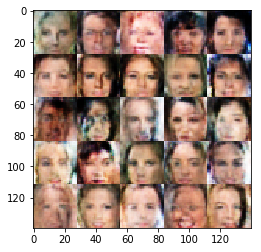

Epoch 1/1 ... Discriminator Loss: 1.1874... Generator Loss: 1.0730
Epoch 1/1 ... Discriminator Loss: 0.9493... Generator Loss: 1.3906
Epoch 1/1 ... Discriminator Loss: 1.0787... Generator Loss: 1.3991
Epoch 1/1 ... Discriminator Loss: 1.3287... Generator Loss: 0.7689
Epoch 1/1 ... Discriminator Loss: 1.1105... Generator Loss: 1.0192
Epoch 1/1 ... Discriminator Loss: 1.2761... Generator Loss: 0.6883
Epoch 1/1 ... Discriminator Loss: 0.9355... Generator Loss: 1.5068
Epoch 1/1 ... Discriminator Loss: 0.8807... Generator Loss: 1.2630
Epoch 1/1 ... Discriminator Loss: 1.1576... Generator Loss: 0.9668
Epoch 1/1 ... Discriminator Loss: 1.2740... Generator Loss: 1.4979


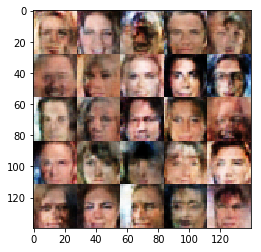

Epoch 1/1 ... Discriminator Loss: 1.1141... Generator Loss: 1.0882
Epoch 1/1 ... Discriminator Loss: 1.2117... Generator Loss: 2.0939
Epoch 1/1 ... Discriminator Loss: 1.2757... Generator Loss: 1.1161
Epoch 1/1 ... Discriminator Loss: 1.0029... Generator Loss: 1.4822
Epoch 1/1 ... Discriminator Loss: 0.9954... Generator Loss: 1.0726
Epoch 1/1 ... Discriminator Loss: 1.4028... Generator Loss: 0.6677
Epoch 1/1 ... Discriminator Loss: 1.0231... Generator Loss: 1.1066
Epoch 1/1 ... Discriminator Loss: 1.1539... Generator Loss: 0.8730
Epoch 1/1 ... Discriminator Loss: 0.9799... Generator Loss: 1.2723
Epoch 1/1 ... Discriminator Loss: 1.1011... Generator Loss: 1.9314


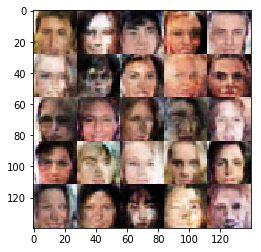

Epoch 1/1 ... Discriminator Loss: 0.9918... Generator Loss: 1.4028
Epoch 1/1 ... Discriminator Loss: 1.0760... Generator Loss: 0.9151
Epoch 1/1 ... Discriminator Loss: 1.2748... Generator Loss: 1.8934
Epoch 1/1 ... Discriminator Loss: 0.8489... Generator Loss: 1.2019
Epoch 1/1 ... Discriminator Loss: 0.8839... Generator Loss: 1.0999
Epoch 1/1 ... Discriminator Loss: 1.2106... Generator Loss: 1.2719
Epoch 1/1 ... Discriminator Loss: 1.2875... Generator Loss: 0.6936
Epoch 1/1 ... Discriminator Loss: 1.0761... Generator Loss: 0.8381
Epoch 1/1 ... Discriminator Loss: 0.9458... Generator Loss: 1.2467
Epoch 1/1 ... Discriminator Loss: 1.0275... Generator Loss: 1.1197


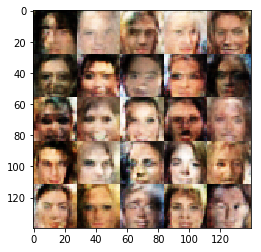

Epoch 1/1 ... Discriminator Loss: 1.4193... Generator Loss: 1.0846
Epoch 1/1 ... Discriminator Loss: 1.1182... Generator Loss: 1.0003
Epoch 1/1 ... Discriminator Loss: 1.0524... Generator Loss: 1.3516
Epoch 1/1 ... Discriminator Loss: 0.7100... Generator Loss: 1.4540
Epoch 1/1 ... Discriminator Loss: 1.0783... Generator Loss: 1.2332
Epoch 1/1 ... Discriminator Loss: 1.1792... Generator Loss: 1.2272
Epoch 1/1 ... Discriminator Loss: 0.8632... Generator Loss: 1.6134
Epoch 1/1 ... Discriminator Loss: 0.9123... Generator Loss: 1.3033
Epoch 1/1 ... Discriminator Loss: 1.4941... Generator Loss: 1.3740
Epoch 1/1 ... Discriminator Loss: 1.1187... Generator Loss: 1.2793


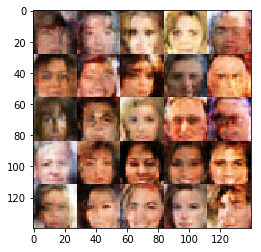

Epoch 1/1 ... Discriminator Loss: 1.1205... Generator Loss: 1.1691
Epoch 1/1 ... Discriminator Loss: 1.0941... Generator Loss: 1.1548
Epoch 1/1 ... Discriminator Loss: 1.0332... Generator Loss: 1.0265
Epoch 1/1 ... Discriminator Loss: 1.0461... Generator Loss: 1.0324
Epoch 1/1 ... Discriminator Loss: 1.0782... Generator Loss: 0.9125
Epoch 1/1 ... Discriminator Loss: 1.1096... Generator Loss: 0.8335
Epoch 1/1 ... Discriminator Loss: 0.9022... Generator Loss: 1.3578
Epoch 1/1 ... Discriminator Loss: 1.1582... Generator Loss: 1.0069
Epoch 1/1 ... Discriminator Loss: 0.8239... Generator Loss: 1.8560
Epoch 1/1 ... Discriminator Loss: 1.0751... Generator Loss: 0.7315


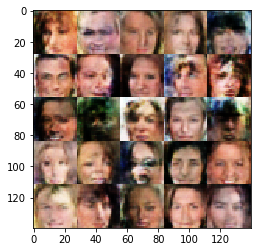

Epoch 1/1 ... Discriminator Loss: 1.0051... Generator Loss: 0.9857
Epoch 1/1 ... Discriminator Loss: 1.1539... Generator Loss: 1.1295
Epoch 1/1 ... Discriminator Loss: 1.0646... Generator Loss: 0.9736
Epoch 1/1 ... Discriminator Loss: 1.1508... Generator Loss: 1.4075
Epoch 1/1 ... Discriminator Loss: 1.0390... Generator Loss: 1.2565
Epoch 1/1 ... Discriminator Loss: 0.9637... Generator Loss: 1.2305
Epoch 1/1 ... Discriminator Loss: 1.0663... Generator Loss: 1.1984
Epoch 1/1 ... Discriminator Loss: 1.1360... Generator Loss: 1.5049
Epoch 1/1 ... Discriminator Loss: 0.8867... Generator Loss: 1.2534
Epoch 1/1 ... Discriminator Loss: 0.9375... Generator Loss: 1.4753


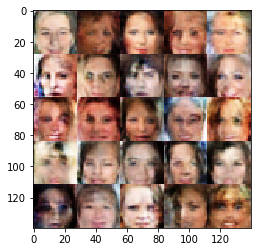

Epoch 1/1 ... Discriminator Loss: 0.9894... Generator Loss: 1.3822
Epoch 1/1 ... Discriminator Loss: 1.1844... Generator Loss: 0.9489
Epoch 1/1 ... Discriminator Loss: 0.7149... Generator Loss: 1.6575
Epoch 1/1 ... Discriminator Loss: 0.9201... Generator Loss: 1.4565
Epoch 1/1 ... Discriminator Loss: 0.8581... Generator Loss: 1.5699
Epoch 1/1 ... Discriminator Loss: 0.9748... Generator Loss: 1.6100
Epoch 1/1 ... Discriminator Loss: 1.0855... Generator Loss: 1.0753
Epoch 1/1 ... Discriminator Loss: 1.0195... Generator Loss: 1.6203
Epoch 1/1 ... Discriminator Loss: 1.1175... Generator Loss: 0.7233
Epoch 1/1 ... Discriminator Loss: 0.9935... Generator Loss: 0.9322


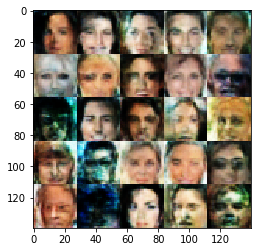

Epoch 1/1 ... Discriminator Loss: 1.0652... Generator Loss: 1.1425
Epoch 1/1 ... Discriminator Loss: 1.1266... Generator Loss: 1.1646
Epoch 1/1 ... Discriminator Loss: 0.9715... Generator Loss: 1.2747
Epoch 1/1 ... Discriminator Loss: 1.2527... Generator Loss: 0.9265
Epoch 1/1 ... Discriminator Loss: 1.2414... Generator Loss: 0.7951
Epoch 1/1 ... Discriminator Loss: 0.9185... Generator Loss: 1.2418
Epoch 1/1 ... Discriminator Loss: 1.1873... Generator Loss: 1.2238
Epoch 1/1 ... Discriminator Loss: 1.0494... Generator Loss: 1.0379
Epoch 1/1 ... Discriminator Loss: 0.9240... Generator Loss: 1.0646
Epoch 1/1 ... Discriminator Loss: 1.0241... Generator Loss: 1.5437


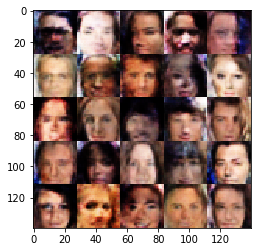

Epoch 1/1 ... Discriminator Loss: 1.0774... Generator Loss: 1.2531
Epoch 1/1 ... Discriminator Loss: 1.0138... Generator Loss: 1.9408
Epoch 1/1 ... Discriminator Loss: 1.0930... Generator Loss: 1.6244
Epoch 1/1 ... Discriminator Loss: 1.0461... Generator Loss: 1.1552
Epoch 1/1 ... Discriminator Loss: 1.0185... Generator Loss: 1.6176
Epoch 1/1 ... Discriminator Loss: 0.8300... Generator Loss: 1.2258
Epoch 1/1 ... Discriminator Loss: 0.9944... Generator Loss: 1.3839
Epoch 1/1 ... Discriminator Loss: 0.9147... Generator Loss: 1.1276
Epoch 1/1 ... Discriminator Loss: 1.0250... Generator Loss: 1.1207
Epoch 1/1 ... Discriminator Loss: 0.8511... Generator Loss: 1.0924


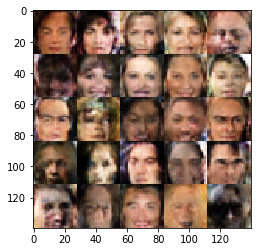

Epoch 1/1 ... Discriminator Loss: 1.1380... Generator Loss: 1.0506
Epoch 1/1 ... Discriminator Loss: 1.0606... Generator Loss: 1.0495
Epoch 1/1 ... Discriminator Loss: 1.1987... Generator Loss: 0.9996
Epoch 1/1 ... Discriminator Loss: 1.1187... Generator Loss: 1.3237
Epoch 1/1 ... Discriminator Loss: 1.1564... Generator Loss: 0.9861
Epoch 1/1 ... Discriminator Loss: 1.2796... Generator Loss: 0.7012
Epoch 1/1 ... Discriminator Loss: 0.9251... Generator Loss: 1.4892
Epoch 1/1 ... Discriminator Loss: 1.0678... Generator Loss: 0.9122
Epoch 1/1 ... Discriminator Loss: 1.0744... Generator Loss: 1.1383
Epoch 1/1 ... Discriminator Loss: 0.9485... Generator Loss: 1.6464


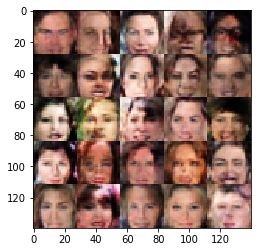

Epoch 1/1 ... Discriminator Loss: 0.8916... Generator Loss: 1.7213
Epoch 1/1 ... Discriminator Loss: 1.1449... Generator Loss: 0.9935
Epoch 1/1 ... Discriminator Loss: 0.7821... Generator Loss: 1.4246
Epoch 1/1 ... Discriminator Loss: 1.0899... Generator Loss: 1.9299
Epoch 1/1 ... Discriminator Loss: 1.1547... Generator Loss: 0.8179
Epoch 1/1 ... Discriminator Loss: 1.1594... Generator Loss: 0.7659
Epoch 1/1 ... Discriminator Loss: 1.0088... Generator Loss: 0.8453
Epoch 1/1 ... Discriminator Loss: 0.8202... Generator Loss: 1.8795
Epoch 1/1 ... Discriminator Loss: 1.0713... Generator Loss: 1.0089
Epoch 1/1 ... Discriminator Loss: 1.2460... Generator Loss: 0.6203


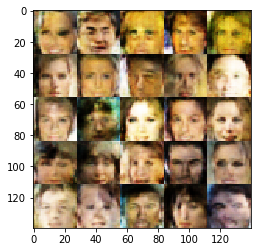

Epoch 1/1 ... Discriminator Loss: 1.1723... Generator Loss: 0.8262
Epoch 1/1 ... Discriminator Loss: 1.2039... Generator Loss: 0.8773
Epoch 1/1 ... Discriminator Loss: 1.0994... Generator Loss: 0.8592
Epoch 1/1 ... Discriminator Loss: 1.1508... Generator Loss: 1.2144
Epoch 1/1 ... Discriminator Loss: 1.1407... Generator Loss: 1.8220
Epoch 1/1 ... Discriminator Loss: 0.8922... Generator Loss: 1.5449
Epoch 1/1 ... Discriminator Loss: 1.3203... Generator Loss: 0.6548
Epoch 1/1 ... Discriminator Loss: 0.7913... Generator Loss: 1.2346
Epoch 1/1 ... Discriminator Loss: 1.2521... Generator Loss: 0.9786
Epoch 1/1 ... Discriminator Loss: 1.0944... Generator Loss: 1.0163


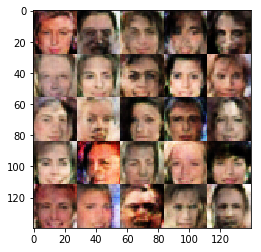

Epoch 1/1 ... Discriminator Loss: 0.8822... Generator Loss: 1.2895
Epoch 1/1 ... Discriminator Loss: 0.9719... Generator Loss: 1.4521
Epoch 1/1 ... Discriminator Loss: 1.0140... Generator Loss: 1.2767
Epoch 1/1 ... Discriminator Loss: 0.9558... Generator Loss: 1.0971
Epoch 1/1 ... Discriminator Loss: 1.1708... Generator Loss: 1.5471
Epoch 1/1 ... Discriminator Loss: 0.9553... Generator Loss: 1.2571
Epoch 1/1 ... Discriminator Loss: 1.1599... Generator Loss: 0.8183
Epoch 1/1 ... Discriminator Loss: 0.9467... Generator Loss: 1.0433
Epoch 1/1 ... Discriminator Loss: 1.1804... Generator Loss: 1.2636
Epoch 1/1 ... Discriminator Loss: 0.9736... Generator Loss: 1.2227


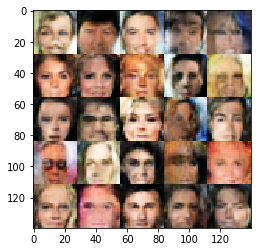

Epoch 1/1 ... Discriminator Loss: 0.9543... Generator Loss: 1.0997
Epoch 1/1 ... Discriminator Loss: 1.0789... Generator Loss: 0.9053
Epoch 1/1 ... Discriminator Loss: 1.4586... Generator Loss: 0.5812
Epoch 1/1 ... Discriminator Loss: 1.0369... Generator Loss: 1.2317
Epoch 1/1 ... Discriminator Loss: 1.1157... Generator Loss: 1.1353
Epoch 1/1 ... Discriminator Loss: 1.2409... Generator Loss: 1.2628
Epoch 1/1 ... Discriminator Loss: 1.0228... Generator Loss: 1.0345
Epoch 1/1 ... Discriminator Loss: 0.9641... Generator Loss: 1.1783
Epoch 1/1 ... Discriminator Loss: 0.9610... Generator Loss: 1.7539
Epoch 1/1 ... Discriminator Loss: 1.1597... Generator Loss: 0.8646


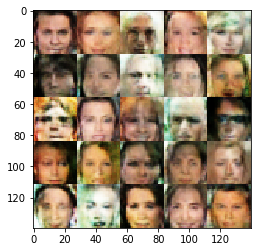

Epoch 1/1 ... Discriminator Loss: 0.9519... Generator Loss: 1.6605
Epoch 1/1 ... Discriminator Loss: 1.0170... Generator Loss: 1.2949
Epoch 1/1 ... Discriminator Loss: 1.0628... Generator Loss: 0.9059
Epoch 1/1 ... Discriminator Loss: 0.9665... Generator Loss: 1.9826
Epoch 1/1 ... Discriminator Loss: 1.0993... Generator Loss: 1.6362
Epoch 1/1 ... Discriminator Loss: 0.8042... Generator Loss: 1.5542
Epoch 1/1 ... Discriminator Loss: 1.3769... Generator Loss: 0.9017
Epoch 1/1 ... Discriminator Loss: 1.3346... Generator Loss: 0.6715
Epoch 1/1 ... Discriminator Loss: 1.0920... Generator Loss: 0.8548
Epoch 1/1 ... Discriminator Loss: 1.1354... Generator Loss: 1.2573


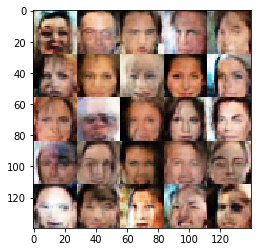

Epoch 1/1 ... Discriminator Loss: 1.1354... Generator Loss: 1.2702
Epoch 1/1 ... Discriminator Loss: 1.0282... Generator Loss: 1.2682
Epoch 1/1 ... Discriminator Loss: 1.0090... Generator Loss: 1.0583
Epoch 1/1 ... Discriminator Loss: 0.8305... Generator Loss: 1.4871
Epoch 1/1 ... Discriminator Loss: 0.8504... Generator Loss: 1.8301
Epoch 1/1 ... Discriminator Loss: 1.0686... Generator Loss: 0.8759
Epoch 1/1 ... Discriminator Loss: 1.0399... Generator Loss: 1.0994
Epoch 1/1 ... Discriminator Loss: 1.3593... Generator Loss: 0.9121
Epoch 1/1 ... Discriminator Loss: 0.9700... Generator Loss: 1.1485
Epoch 1/1 ... Discriminator Loss: 0.9705... Generator Loss: 1.6349


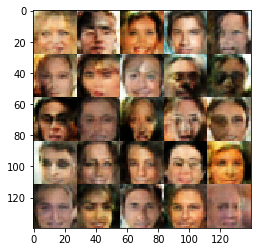

Epoch 1/1 ... Discriminator Loss: 1.0646... Generator Loss: 1.0725
Epoch 1/1 ... Discriminator Loss: 1.1332... Generator Loss: 1.2543
Epoch 1/1 ... Discriminator Loss: 0.9980... Generator Loss: 1.0475
Epoch 1/1 ... Discriminator Loss: 0.9924... Generator Loss: 0.9494
Epoch 1/1 ... Discriminator Loss: 1.2909... Generator Loss: 0.5136
Epoch 1/1 ... Discriminator Loss: 1.0419... Generator Loss: 1.5713
Epoch 1/1 ... Discriminator Loss: 0.9726... Generator Loss: 1.4575
Epoch 1/1 ... Discriminator Loss: 1.2880... Generator Loss: 0.9957
Epoch 1/1 ... Discriminator Loss: 0.9618... Generator Loss: 0.8646
Epoch 1/1 ... Discriminator Loss: 0.8224... Generator Loss: 1.6098


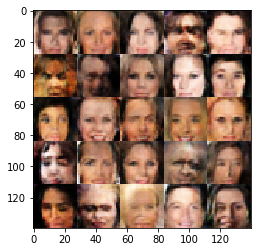

Epoch 1/1 ... Discriminator Loss: 1.3075... Generator Loss: 0.7303
Epoch 1/1 ... Discriminator Loss: 1.0225... Generator Loss: 1.1022
Epoch 1/1 ... Discriminator Loss: 1.2351... Generator Loss: 0.7020
Epoch 1/1 ... Discriminator Loss: 1.1312... Generator Loss: 0.9938
Epoch 1/1 ... Discriminator Loss: 1.2937... Generator Loss: 1.4445
Epoch 1/1 ... Discriminator Loss: 0.9260... Generator Loss: 1.7301
Epoch 1/1 ... Discriminator Loss: 0.9527... Generator Loss: 1.0224
Epoch 1/1 ... Discriminator Loss: 0.6759... Generator Loss: 1.6456
Epoch 1/1 ... Discriminator Loss: 1.1062... Generator Loss: 0.9769
Epoch 1/1 ... Discriminator Loss: 0.7568... Generator Loss: 1.8354


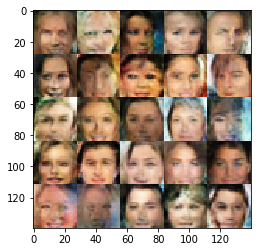

Epoch 1/1 ... Discriminator Loss: 1.1399... Generator Loss: 0.9844
Epoch 1/1 ... Discriminator Loss: 0.9979... Generator Loss: 1.3264
Epoch 1/1 ... Discriminator Loss: 0.9606... Generator Loss: 1.1293
Epoch 1/1 ... Discriminator Loss: 1.0734... Generator Loss: 0.9738
Epoch 1/1 ... Discriminator Loss: 1.0166... Generator Loss: 1.0051
Epoch 1/1 ... Discriminator Loss: 1.0304... Generator Loss: 1.4417
Epoch 1/1 ... Discriminator Loss: 0.9549... Generator Loss: 1.1489
Epoch 1/1 ... Discriminator Loss: 1.2038... Generator Loss: 0.8383
Epoch 1/1 ... Discriminator Loss: 0.8794... Generator Loss: 1.6069
Epoch 1/1 ... Discriminator Loss: 1.0196... Generator Loss: 1.4833


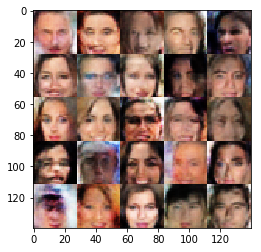

Epoch 1/1 ... Discriminator Loss: 1.2225... Generator Loss: 1.3318
Epoch 1/1 ... Discriminator Loss: 0.9523... Generator Loss: 1.3960
Epoch 1/1 ... Discriminator Loss: 1.1100... Generator Loss: 1.0291
Epoch 1/1 ... Discriminator Loss: 1.3591... Generator Loss: 0.5603
Epoch 1/1 ... Discriminator Loss: 0.9865... Generator Loss: 0.9308
Epoch 1/1 ... Discriminator Loss: 1.0025... Generator Loss: 1.4137
Epoch 1/1 ... Discriminator Loss: 1.5896... Generator Loss: 2.2886
Epoch 1/1 ... Discriminator Loss: 1.0245... Generator Loss: 1.1159
Epoch 1/1 ... Discriminator Loss: 0.9647... Generator Loss: 1.1689
Epoch 1/1 ... Discriminator Loss: 1.0204... Generator Loss: 1.0720


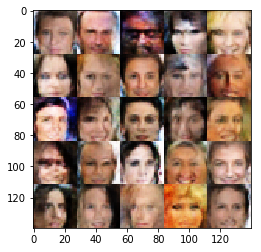

Epoch 1/1 ... Discriminator Loss: 0.8492... Generator Loss: 1.0997
Epoch 1/1 ... Discriminator Loss: 1.4335... Generator Loss: 0.7623
Epoch 1/1 ... Discriminator Loss: 0.9479... Generator Loss: 1.4101
Epoch 1/1 ... Discriminator Loss: 0.7929... Generator Loss: 1.7075
Epoch 1/1 ... Discriminator Loss: 1.6895... Generator Loss: 0.4617
Epoch 1/1 ... Discriminator Loss: 1.0131... Generator Loss: 1.0501
Epoch 1/1 ... Discriminator Loss: 0.9149... Generator Loss: 1.6425
Epoch 1/1 ... Discriminator Loss: 0.9587... Generator Loss: 0.9265
Epoch 1/1 ... Discriminator Loss: 1.1236... Generator Loss: 1.6076
Epoch 1/1 ... Discriminator Loss: 0.9208... Generator Loss: 1.6949


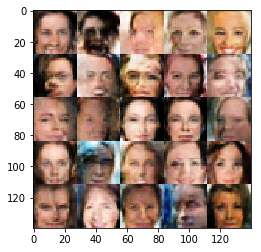

Epoch 1/1 ... Discriminator Loss: 0.9698... Generator Loss: 1.0572
Epoch 1/1 ... Discriminator Loss: 0.9380... Generator Loss: 1.1881
Epoch 1/1 ... Discriminator Loss: 0.9438... Generator Loss: 1.3591
Epoch 1/1 ... Discriminator Loss: 1.3167... Generator Loss: 1.4905
Epoch 1/1 ... Discriminator Loss: 0.9635... Generator Loss: 1.1517
Epoch 1/1 ... Discriminator Loss: 0.6855... Generator Loss: 1.5138
Epoch 1/1 ... Discriminator Loss: 1.3014... Generator Loss: 0.9445
Epoch 1/1 ... Discriminator Loss: 0.9637... Generator Loss: 1.8947
Epoch 1/1 ... Discriminator Loss: 1.0479... Generator Loss: 1.7448
Epoch 1/1 ... Discriminator Loss: 0.9875... Generator Loss: 0.8997


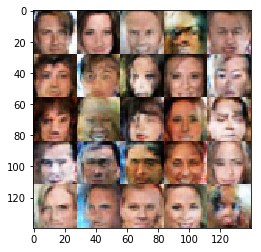

Epoch 1/1 ... Discriminator Loss: 1.3632... Generator Loss: 0.6601
Epoch 1/1 ... Discriminator Loss: 0.7905... Generator Loss: 1.3326
Epoch 1/1 ... Discriminator Loss: 1.6512... Generator Loss: 0.5326
Epoch 1/1 ... Discriminator Loss: 0.9089... Generator Loss: 0.8214
Epoch 1/1 ... Discriminator Loss: 1.0353... Generator Loss: 1.2155
Epoch 1/1 ... Discriminator Loss: 0.8672... Generator Loss: 1.1170
Epoch 1/1 ... Discriminator Loss: 1.0069... Generator Loss: 1.5603
Epoch 1/1 ... Discriminator Loss: 1.2096... Generator Loss: 0.8807
Epoch 1/1 ... Discriminator Loss: 1.0590... Generator Loss: 1.1584
Epoch 1/1 ... Discriminator Loss: 1.1336... Generator Loss: 1.1077


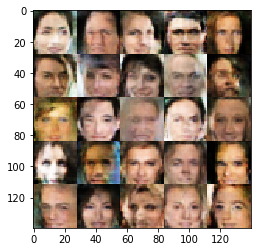

Epoch 1/1 ... Discriminator Loss: 1.3218... Generator Loss: 0.7746
Epoch 1/1 ... Discriminator Loss: 0.7838... Generator Loss: 1.7045
Epoch 1/1 ... Discriminator Loss: 1.0962... Generator Loss: 0.8825
Epoch 1/1 ... Discriminator Loss: 0.8502... Generator Loss: 1.5342
Epoch 1/1 ... Discriminator Loss: 1.0787... Generator Loss: 1.1050
Epoch 1/1 ... Discriminator Loss: 0.9272... Generator Loss: 1.2918
Epoch 1/1 ... Discriminator Loss: 0.7766... Generator Loss: 1.9571
Epoch 1/1 ... Discriminator Loss: 0.9709... Generator Loss: 1.3297
Epoch 1/1 ... Discriminator Loss: 0.8985... Generator Loss: 1.3466
Epoch 1/1 ... Discriminator Loss: 1.1823... Generator Loss: 1.0463


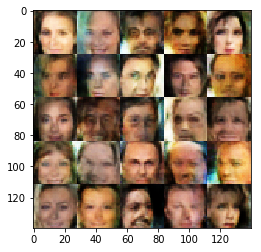

Epoch 1/1 ... Discriminator Loss: 1.1906... Generator Loss: 0.9438
Epoch 1/1 ... Discriminator Loss: 1.0258... Generator Loss: 1.2842
Epoch 1/1 ... Discriminator Loss: 0.8672... Generator Loss: 1.4990
Epoch 1/1 ... Discriminator Loss: 1.0176... Generator Loss: 0.7377
Epoch 1/1 ... Discriminator Loss: 1.1470... Generator Loss: 1.5537
Epoch 1/1 ... Discriminator Loss: 1.5729... Generator Loss: 0.6590
Epoch 1/1 ... Discriminator Loss: 1.0195... Generator Loss: 0.9639
Epoch 1/1 ... Discriminator Loss: 1.3214... Generator Loss: 0.5347
Epoch 1/1 ... Discriminator Loss: 1.0960... Generator Loss: 1.9970
Epoch 1/1 ... Discriminator Loss: 1.2366... Generator Loss: 1.0543


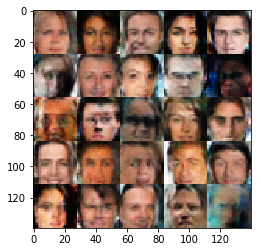

Epoch 1/1 ... Discriminator Loss: 1.1992... Generator Loss: 0.8745
Epoch 1/1 ... Discriminator Loss: 1.0887... Generator Loss: 1.5227
Epoch 1/1 ... Discriminator Loss: 1.1261... Generator Loss: 0.8643
Epoch 1/1 ... Discriminator Loss: 1.0915... Generator Loss: 1.3506
Epoch 1/1 ... Discriminator Loss: 0.9282... Generator Loss: 1.2511
Epoch 1/1 ... Discriminator Loss: 1.2384... Generator Loss: 0.9273
Epoch 1/1 ... Discriminator Loss: 0.8974... Generator Loss: 1.4949
Epoch 1/1 ... Discriminator Loss: 0.9363... Generator Loss: 0.9694
Epoch 1/1 ... Discriminator Loss: 1.2357... Generator Loss: 1.5552
Epoch 1/1 ... Discriminator Loss: 1.0911... Generator Loss: 1.0409


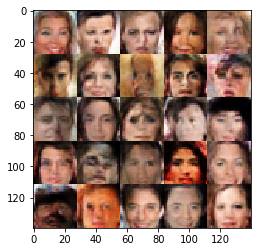

Epoch 1/1 ... Discriminator Loss: 1.0100... Generator Loss: 1.5073
Epoch 1/1 ... Discriminator Loss: 0.8563... Generator Loss: 0.9598
Epoch 1/1 ... Discriminator Loss: 0.7858... Generator Loss: 1.6539
Epoch 1/1 ... Discriminator Loss: 1.3364... Generator Loss: 1.0848
Epoch 1/1 ... Discriminator Loss: 1.3142... Generator Loss: 0.9981
Epoch 1/1 ... Discriminator Loss: 0.7249... Generator Loss: 1.5630
Epoch 1/1 ... Discriminator Loss: 0.8387... Generator Loss: 1.2666
Epoch 1/1 ... Discriminator Loss: 1.2683... Generator Loss: 0.7053
Epoch 1/1 ... Discriminator Loss: 1.2586... Generator Loss: 0.6721
Epoch 1/1 ... Discriminator Loss: 0.8750... Generator Loss: 1.4389


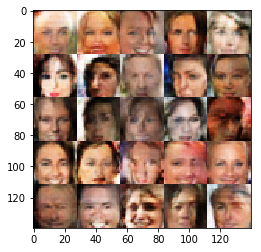

Epoch 1/1 ... Discriminator Loss: 0.6088... Generator Loss: 1.9569
Epoch 1/1 ... Discriminator Loss: 1.1730... Generator Loss: 1.3710
Epoch 1/1 ... Discriminator Loss: 1.1855... Generator Loss: 0.7012
Epoch 1/1 ... Discriminator Loss: 1.1377... Generator Loss: 1.1861
Epoch 1/1 ... Discriminator Loss: 1.0066... Generator Loss: 1.2446
Epoch 1/1 ... Discriminator Loss: 1.0385... Generator Loss: 0.8036
Epoch 1/1 ... Discriminator Loss: 0.9877... Generator Loss: 1.4854
Epoch 1/1 ... Discriminator Loss: 1.1236... Generator Loss: 1.2939
Epoch 1/1 ... Discriminator Loss: 0.9978... Generator Loss: 1.2101
Epoch 1/1 ... Discriminator Loss: 1.0984... Generator Loss: 0.7918


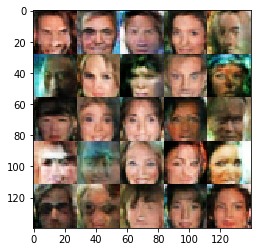

Epoch 1/1 ... Discriminator Loss: 0.9751... Generator Loss: 2.1087
Epoch 1/1 ... Discriminator Loss: 1.0841... Generator Loss: 0.7435
Epoch 1/1 ... Discriminator Loss: 1.0455... Generator Loss: 1.4454
Epoch 1/1 ... Discriminator Loss: 1.3044... Generator Loss: 0.9374
Epoch 1/1 ... Discriminator Loss: 1.3092... Generator Loss: 0.9758
Epoch 1/1 ... Discriminator Loss: 0.8733... Generator Loss: 1.3353
Epoch 1/1 ... Discriminator Loss: 1.1503... Generator Loss: 0.8854
Epoch 1/1 ... Discriminator Loss: 0.9527... Generator Loss: 1.2234
Epoch 1/1 ... Discriminator Loss: 1.0658... Generator Loss: 0.9816
Epoch 1/1 ... Discriminator Loss: 0.9676... Generator Loss: 1.7548


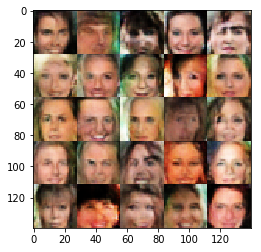

Epoch 1/1 ... Discriminator Loss: 1.0697... Generator Loss: 1.0184
Epoch 1/1 ... Discriminator Loss: 0.8707... Generator Loss: 1.7157
Epoch 1/1 ... Discriminator Loss: 0.9942... Generator Loss: 1.2195
Epoch 1/1 ... Discriminator Loss: 0.8891... Generator Loss: 1.6825
Epoch 1/1 ... Discriminator Loss: 0.8672... Generator Loss: 1.4909
Epoch 1/1 ... Discriminator Loss: 0.9112... Generator Loss: 1.1832
Epoch 1/1 ... Discriminator Loss: 1.1511... Generator Loss: 0.8490
Epoch 1/1 ... Discriminator Loss: 1.1460... Generator Loss: 0.8578
Epoch 1/1 ... Discriminator Loss: 0.9220... Generator Loss: 1.1232
Epoch 1/1 ... Discriminator Loss: 0.9742... Generator Loss: 1.3598


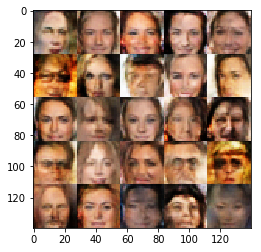

Epoch 1/1 ... Discriminator Loss: 0.9704... Generator Loss: 1.3511
Epoch 1/1 ... Discriminator Loss: 0.8861... Generator Loss: 1.2739
Epoch 1/1 ... Discriminator Loss: 0.8588... Generator Loss: 1.9447
Epoch 1/1 ... Discriminator Loss: 1.3518... Generator Loss: 0.5777
Epoch 1/1 ... Discriminator Loss: 1.0061... Generator Loss: 1.1424
Epoch 1/1 ... Discriminator Loss: 1.0414... Generator Loss: 1.0926
Epoch 1/1 ... Discriminator Loss: 1.1197... Generator Loss: 1.4087
Epoch 1/1 ... Discriminator Loss: 0.9257... Generator Loss: 1.5720
Epoch 1/1 ... Discriminator Loss: 1.0289... Generator Loss: 0.9016
Epoch 1/1 ... Discriminator Loss: 0.9774... Generator Loss: 1.2455


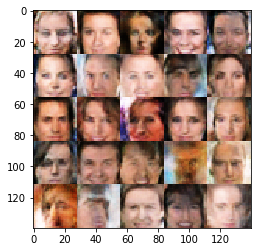

Epoch 1/1 ... Discriminator Loss: 1.2854... Generator Loss: 0.7341
Epoch 1/1 ... Discriminator Loss: 1.0877... Generator Loss: 1.7325
Epoch 1/1 ... Discriminator Loss: 1.1754... Generator Loss: 0.9461
Epoch 1/1 ... Discriminator Loss: 0.7655... Generator Loss: 1.3494
Epoch 1/1 ... Discriminator Loss: 1.2330... Generator Loss: 0.8877
Epoch 1/1 ... Discriminator Loss: 1.0912... Generator Loss: 0.7897
Epoch 1/1 ... Discriminator Loss: 0.8588... Generator Loss: 1.7442
Epoch 1/1 ... Discriminator Loss: 0.9937... Generator Loss: 1.0846
Epoch 1/1 ... Discriminator Loss: 1.3344... Generator Loss: 1.0454
Epoch 1/1 ... Discriminator Loss: 1.0445... Generator Loss: 0.9187


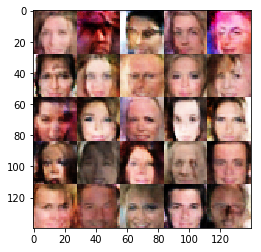

Epoch 1/1 ... Discriminator Loss: 1.1711... Generator Loss: 0.9356
Epoch 1/1 ... Discriminator Loss: 0.8732... Generator Loss: 1.1974
Epoch 1/1 ... Discriminator Loss: 1.2936... Generator Loss: 0.6981
Epoch 1/1 ... Discriminator Loss: 1.0710... Generator Loss: 1.5264
Epoch 1/1 ... Discriminator Loss: 1.0786... Generator Loss: 1.2638
Epoch 1/1 ... Discriminator Loss: 1.1316... Generator Loss: 1.0435
Epoch 1/1 ... Discriminator Loss: 1.1734... Generator Loss: 1.0533
Epoch 1/1 ... Discriminator Loss: 1.0612... Generator Loss: 1.2917
Epoch 1/1 ... Discriminator Loss: 1.0546... Generator Loss: 0.8525
Epoch 1/1 ... Discriminator Loss: 0.8202... Generator Loss: 1.3419


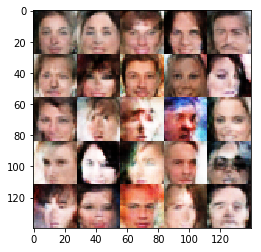

Epoch 1/1 ... Discriminator Loss: 0.9885... Generator Loss: 1.7311
Epoch 1/1 ... Discriminator Loss: 1.1270... Generator Loss: 1.1712
Epoch 1/1 ... Discriminator Loss: 0.9632... Generator Loss: 1.4575
Epoch 1/1 ... Discriminator Loss: 0.8400... Generator Loss: 1.2903
Epoch 1/1 ... Discriminator Loss: 1.0819... Generator Loss: 1.6960
Epoch 1/1 ... Discriminator Loss: 1.1705... Generator Loss: 0.9388
Epoch 1/1 ... Discriminator Loss: 0.9259... Generator Loss: 1.0189
Epoch 1/1 ... Discriminator Loss: 0.9306... Generator Loss: 1.1481
Epoch 1/1 ... Discriminator Loss: 0.8212... Generator Loss: 1.5557
Epoch 1/1 ... Discriminator Loss: 0.9933... Generator Loss: 1.1228


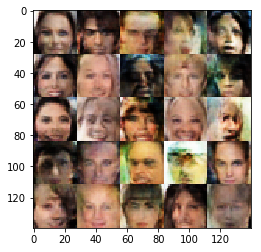

Epoch 1/1 ... Discriminator Loss: 0.9654... Generator Loss: 1.2159
Epoch 1/1 ... Discriminator Loss: 0.8888... Generator Loss: 1.3127
Epoch 1/1 ... Discriminator Loss: 0.9817... Generator Loss: 1.6869
Epoch 1/1 ... Discriminator Loss: 1.0447... Generator Loss: 1.3118
Epoch 1/1 ... Discriminator Loss: 0.9860... Generator Loss: 1.2451
Epoch 1/1 ... Discriminator Loss: 0.9653... Generator Loss: 1.4049
Epoch 1/1 ... Discriminator Loss: 0.9692... Generator Loss: 1.1766
Epoch 1/1 ... Discriminator Loss: 1.1896... Generator Loss: 0.7555
Epoch 1/1 ... Discriminator Loss: 1.1044... Generator Loss: 1.7939
Epoch 1/1 ... Discriminator Loss: 1.2620... Generator Loss: 1.2628


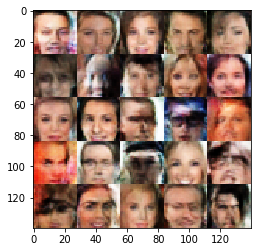

Epoch 1/1 ... Discriminator Loss: 0.7733... Generator Loss: 1.3181
Epoch 1/1 ... Discriminator Loss: 0.9597... Generator Loss: 2.0474
Epoch 1/1 ... Discriminator Loss: 0.9638... Generator Loss: 1.0937
Epoch 1/1 ... Discriminator Loss: 0.9064... Generator Loss: 1.6452
Epoch 1/1 ... Discriminator Loss: 0.9333... Generator Loss: 1.6711
Epoch 1/1 ... Discriminator Loss: 0.9104... Generator Loss: 1.5348
Epoch 1/1 ... Discriminator Loss: 1.0960... Generator Loss: 1.1529
Epoch 1/1 ... Discriminator Loss: 0.9266... Generator Loss: 1.3402
Epoch 1/1 ... Discriminator Loss: 1.0761... Generator Loss: 1.0733
Epoch 1/1 ... Discriminator Loss: 0.9029... Generator Loss: 1.3032


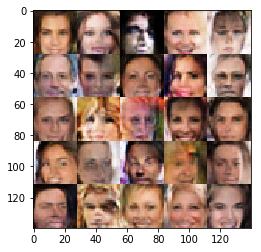

Epoch 1/1 ... Discriminator Loss: 1.0819... Generator Loss: 1.5222
Epoch 1/1 ... Discriminator Loss: 0.9090... Generator Loss: 1.2751
Epoch 1/1 ... Discriminator Loss: 1.3073... Generator Loss: 0.8080
Epoch 1/1 ... Discriminator Loss: 1.4825... Generator Loss: 0.7368
Epoch 1/1 ... Discriminator Loss: 0.8179... Generator Loss: 1.3901
Epoch 1/1 ... Discriminator Loss: 0.9075... Generator Loss: 1.3170
Epoch 1/1 ... Discriminator Loss: 1.1882... Generator Loss: 1.4314
Epoch 1/1 ... Discriminator Loss: 0.9704... Generator Loss: 1.2982
Epoch 1/1 ... Discriminator Loss: 1.1384... Generator Loss: 0.8390
Epoch 1/1 ... Discriminator Loss: 1.0853... Generator Loss: 0.8959


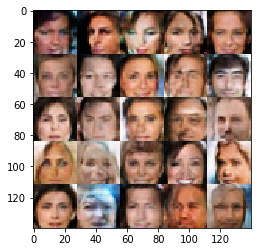

Epoch 1/1 ... Discriminator Loss: 0.9432... Generator Loss: 1.1337
Epoch 1/1 ... Discriminator Loss: 0.8621... Generator Loss: 1.0136
Epoch 1/1 ... Discriminator Loss: 0.9039... Generator Loss: 1.2137
Epoch 1/1 ... Discriminator Loss: 0.9184... Generator Loss: 1.2827
Epoch 1/1 ... Discriminator Loss: 1.2303... Generator Loss: 1.0827
Epoch 1/1 ... Discriminator Loss: 1.0079... Generator Loss: 1.1969
Epoch 1/1 ... Discriminator Loss: 1.1633... Generator Loss: 1.4687
Epoch 1/1 ... Discriminator Loss: 0.9143... Generator Loss: 1.6216
Epoch 1/1 ... Discriminator Loss: 1.2101... Generator Loss: 1.4361
Epoch 1/1 ... Discriminator Loss: 1.2327... Generator Loss: 0.9979


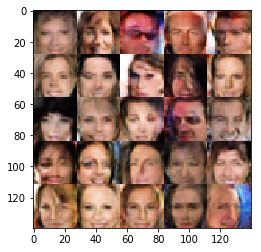

Epoch 1/1 ... Discriminator Loss: 0.8826... Generator Loss: 1.6514
Epoch 1/1 ... Discriminator Loss: 1.1141... Generator Loss: 1.2694
Epoch 1/1 ... Discriminator Loss: 0.9441... Generator Loss: 1.0264
Epoch 1/1 ... Discriminator Loss: 0.9705... Generator Loss: 1.1241
Epoch 1/1 ... Discriminator Loss: 1.2452... Generator Loss: 1.1589
Epoch 1/1 ... Discriminator Loss: 1.0559... Generator Loss: 1.0577
Epoch 1/1 ... Discriminator Loss: 0.9900... Generator Loss: 1.2162
Epoch 1/1 ... Discriminator Loss: 0.8516... Generator Loss: 1.1192
Epoch 1/1 ... Discriminator Loss: 1.2682... Generator Loss: 0.8510
Epoch 1/1 ... Discriminator Loss: 0.8894... Generator Loss: 1.1196


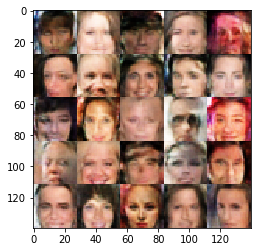

Epoch 1/1 ... Discriminator Loss: 0.8988... Generator Loss: 1.4620
Epoch 1/1 ... Discriminator Loss: 1.1357... Generator Loss: 1.0577
Epoch 1/1 ... Discriminator Loss: 1.0416... Generator Loss: 1.0857
Epoch 1/1 ... Discriminator Loss: 1.0439... Generator Loss: 1.5894
Epoch 1/1 ... Discriminator Loss: 1.0638... Generator Loss: 1.1555
Epoch 1/1 ... Discriminator Loss: 0.9819... Generator Loss: 0.8287
Epoch 1/1 ... Discriminator Loss: 1.0322... Generator Loss: 1.3698
Epoch 1/1 ... Discriminator Loss: 1.0776... Generator Loss: 2.2448
Epoch 1/1 ... Discriminator Loss: 1.0662... Generator Loss: 1.0276
Epoch 1/1 ... Discriminator Loss: 1.2361... Generator Loss: 1.5725


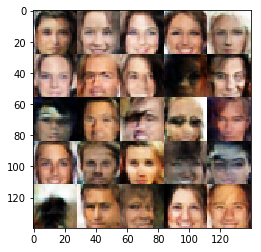

Epoch 1/1 ... Discriminator Loss: 1.2046... Generator Loss: 0.8407
Epoch 1/1 ... Discriminator Loss: 0.9639... Generator Loss: 1.5865
Epoch 1/1 ... Discriminator Loss: 1.0896... Generator Loss: 1.4575
Epoch 1/1 ... Discriminator Loss: 1.2862... Generator Loss: 0.7172
Epoch 1/1 ... Discriminator Loss: 1.0578... Generator Loss: 1.0666
Epoch 1/1 ... Discriminator Loss: 1.0199... Generator Loss: 1.2050
Epoch 1/1 ... Discriminator Loss: 0.9691... Generator Loss: 1.1796
Epoch 1/1 ... Discriminator Loss: 1.0430... Generator Loss: 1.0758
Epoch 1/1 ... Discriminator Loss: 1.3178... Generator Loss: 0.8121
Epoch 1/1 ... Discriminator Loss: 0.7885... Generator Loss: 1.2748


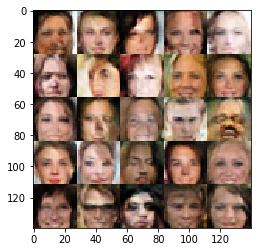

Epoch 1/1 ... Discriminator Loss: 1.2377... Generator Loss: 1.1659
Epoch 1/1 ... Discriminator Loss: 0.9800... Generator Loss: 1.3356
Epoch 1/1 ... Discriminator Loss: 1.1815... Generator Loss: 0.8100
Epoch 1/1 ... Discriminator Loss: 1.1099... Generator Loss: 1.1007
Epoch 1/1 ... Discriminator Loss: 1.2163... Generator Loss: 0.8237
Epoch 1/1 ... Discriminator Loss: 0.9027... Generator Loss: 1.6703
Epoch 1/1 ... Discriminator Loss: 0.8972... Generator Loss: 1.6441
Epoch 1/1 ... Discriminator Loss: 0.8414... Generator Loss: 0.8626
Epoch 1/1 ... Discriminator Loss: 1.0964... Generator Loss: 1.3134
Epoch 1/1 ... Discriminator Loss: 0.9653... Generator Loss: 1.6501


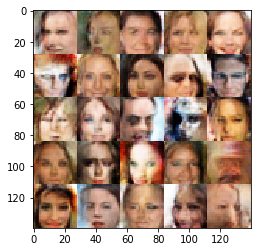

Epoch 1/1 ... Discriminator Loss: 0.8188... Generator Loss: 1.5127
Epoch 1/1 ... Discriminator Loss: 1.1577... Generator Loss: 0.9529
Epoch 1/1 ... Discriminator Loss: 1.1053... Generator Loss: 1.4539
Epoch 1/1 ... Discriminator Loss: 0.9196... Generator Loss: 1.2072
Epoch 1/1 ... Discriminator Loss: 1.1215... Generator Loss: 1.5887
Epoch 1/1 ... Discriminator Loss: 0.9107... Generator Loss: 1.1550
Epoch 1/1 ... Discriminator Loss: 1.0055... Generator Loss: 1.0005
Epoch 1/1 ... Discriminator Loss: 0.8508... Generator Loss: 1.2192
Epoch 1/1 ... Discriminator Loss: 0.8611... Generator Loss: 1.2463
Epoch 1/1 ... Discriminator Loss: 1.1541... Generator Loss: 0.7831


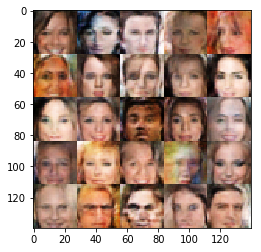

Epoch 1/1 ... Discriminator Loss: 0.9668... Generator Loss: 0.9586
Epoch 1/1 ... Discriminator Loss: 1.2007... Generator Loss: 0.9828
Epoch 1/1 ... Discriminator Loss: 1.0738... Generator Loss: 1.3505
Epoch 1/1 ... Discriminator Loss: 0.7393... Generator Loss: 1.7623
Epoch 1/1 ... Discriminator Loss: 1.2777... Generator Loss: 0.8428
Epoch 1/1 ... Discriminator Loss: 1.1213... Generator Loss: 1.1265
Epoch 1/1 ... Discriminator Loss: 1.0968... Generator Loss: 0.7165
Epoch 1/1 ... Discriminator Loss: 0.7305... Generator Loss: 2.0215
Epoch 1/1 ... Discriminator Loss: 1.3290... Generator Loss: 2.3286
Epoch 1/1 ... Discriminator Loss: 1.0875... Generator Loss: 0.7344


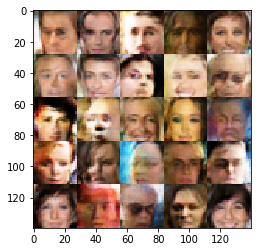

Epoch 1/1 ... Discriminator Loss: 0.9396... Generator Loss: 1.7232
Epoch 1/1 ... Discriminator Loss: 1.1592... Generator Loss: 1.0813
Epoch 1/1 ... Discriminator Loss: 0.9743... Generator Loss: 1.9896


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.